In [1]:
import os

from huggingface_hub import notebook_login
notebook_login()

In [2]:
!pip uninstall -y bitsandbytes
!pip install --no-cache-dir bitsandbytes
!pip install --upgrade accelerate

Found existing installation: bitsandbytes 0.45.3
Uninstalling bitsandbytes-0.45.3:
  Successfully uninstalled bitsandbytes-0.45.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 293.3 MB/s eta 0:00:00


In [3]:
pip install np faiss-cpu sentence-transformers peft rouge_score bert_score pymupdf4llm pdfplumber rank_bm25 evaluate

In [4]:
#!/usr/bin/env python
import argparse
import json
import time
import re
import os
import csv
import numpy as np
import torch
import faiss
import matplotlib.pyplot as plt
import pandas as pd
import string
from pathlib import Path
from typing import List, Dict
from collections import defaultdict
import evaluate


from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util
from peft import LoraConfig, get_peft_model
from tqdm import tqdm



# Use your PDF-to-markdown converter; here we use pymupdf4llm as in your snippet.
import pymupdf4llm

# For alternative PDF extraction (if needed)
import pdfplumber



# For TF-IDF retrieval:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# For BM25 retrieval:
from rank_bm25 import BM25Okapi

# ========================================================
# 1. Mount Google Drive
# ========================================================

from google.colab import drive
drive.mount('/content/drive')



##############################
# CONFIGURATION
##############################

# Maximum token limit for each chunk (set below 512 to allow room for question tokens and special tokens)
MAX_CHUNK_TOKENS = 400

# Choose a tokenizer for counting tokens (using a BERT tokenizer as an example)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:

# In Google Colab, if your notebook is in /content and the files are as above:
BASE_DIR = Path("/content/drive/My Drive/Dissertation/phase_2/generative")
AGREEMENTS_DIR = BASE_DIR / "agreements"
GOLD_STANDARD_JSON = BASE_DIR / "gold_standard.json"
PROCESSED_DIR = BASE_DIR / "processed"         # output for processed main PDFs
IMAGES_DIR = BASE_DIR / "images"



print("Base Directory:", BASE_DIR)
print("Agreements Directory:", AGREEMENTS_DIR)
print("Gold Standard JSON:", GOLD_STANDARD_JSON)


Base Directory: /content/drive/My Drive/Dissertation/phase_2/generative
Agreements Directory: /content/drive/My Drive/Dissertation/phase_2/generative/agreements
Gold Standard JSON: /content/drive/My Drive/Dissertation/phase_2/generative/gold_standard.json


# PDF PREPROCESSING & MARKDOWN EXTRACTION

In [6]:
def pdf_to_markdown(pdf_path: Path) -> str:

    """
    Convert a PDF to markdown using pymupdf4llm.
    If there are issues with pymupdf4llm, consider switching to pdfplumber.
    """

    return pymupdf4llm.to_markdown(str(pdf_path))

def clean_text(text: str) -> str:

    """
    Remove unwanted artifacts and non-ASCII characters.
    """

    text = re.sub(r'â', '', text)
    text = re.sub(r'\*+', '', text)
    text = re.sub(r'â*', '', text)
    text = text.encode("ascii", errors="ignore").decode("ascii")

    return text.strip()

def split_markdown_by_headers(markdown: str) -> List[Dict[str, str]]:

    """
    Splits markdown text into sections based on headers.
    Returns a list of dicts with keys 'title' and 'content'.
    """

    sections = []
    current_section = {"title": None, "content": ""}

    for line in markdown.splitlines():

        header_match = re.match(r'^(#{1,6})\s+(.*)', line)
        if header_match:
            if current_section["title"] is not None or current_section["content"].strip():
                sections.append(current_section)
            title = header_match.group(2).strip()
            current_section = {"title": title, "content": ""}
        else:
            current_section["content"] += line + "\n"

    if current_section["title"] is not None or current_section["content"].strip():
        sections.append(current_section)

    return sections

def process_content(text: str) -> str:

    """
    Replace newline characters with a space and collapse extra spaces.
    """

    text = text.replace("\n", " ")
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def preprocess_markdown_file(file_path: Path) -> List[Dict[str, str]]:

    """
    Process a markdown file: clean, split by headers, process content,
    and filter out trivial sections.
    """

    with open(file_path, 'r', encoding='utf-8') as f:
        markdown = f.read()
    markdown = clean_text(markdown)
    sections = split_markdown_by_headers(markdown)

    for sec in sections:
        sec["content"] = process_content(sec["content"])

    # Filter out sections that are too trivial
    filtered_sections = []

    for sec in sections:

        if not sec["content"].strip():
            continue
        filtered_sections.append(sec)

    return filtered_sections

def save_to_json(data, filename: Path):

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

    print(f"Data saved to {filename}")

def process_all_agreement_pdfs():

    """
    Loop over all main agreement PDFs (skip Q&A PDFs that contain '_QA' in the filename)
    and produce a JSON file per agreement.
    """

    for pdf_file in AGREEMENTS_DIR.glob("Agreement_*.pdf"):

        if "_QA" in pdf_file.stem:
            continue  # Skip Q&A PDFs
        print(f"Processing {pdf_file.name} ...")

        # Convert PDF to markdown text.
        md_text = pdf_to_markdown(pdf_file)

        # Save the markdown to the output directory using the correct path.
        output_md_path = AGREEMENTS_DIR / f"{pdf_file.stem}.md"
        output_md_path.write_text(md_text, encoding="utf-8")
        print(f"Saved markdown to {output_md_path}")

        sections = preprocess_markdown_file(pdf_file.with_suffix(".md"))
        # In case you haven't already saved markdown to disk, you can also do:
        # sections = split_markdown_by_headers(clean_text(md_text))
        # Save processed sections to JSON:
        output_json = PROCESSED_DIR / f"{pdf_file.stem}.json"
        save_to_json(sections, output_json)


##############################
# FURTHER CHUNKING USING TOKEN COUNTS
##############################

def chunk_section_by_tokens(section: Dict[str, str], max_tokens: int = MAX_CHUNK_TOKENS) -> List[Dict[str, str]]:

    """
    Use the Hugging Face tokenizer to count tokens and split a section's content into sub‐chunks.
    The method splits on sentence boundaries if possible.
    """

    text = section["content"]

    # Tokenize using the model's tokenizer (which returns token IDs)
    tokens = tokenizer.tokenize(text)

    if len(tokens) <= max_tokens:
        return [section]

    # For a better split, we can try to split by sentences.
    # Here we use a naive regex sentence split; you might also use nltk.sent_tokenize.
    sentences = re.split(r'(?<=[.!?])\s+', text)
    chunks = []
    current_chunk = ""
    current_tokens = []

    for sent in sentences:
        sent_tokens = tokenizer.tokenize(sent)

        # If adding the sentence exceeds max_tokens, store the current chunk.
        if len(current_tokens) + len(sent_tokens) > max_tokens:
            if current_chunk:
                chunks.append({
                    "title": section["title"],
                    "content": current_chunk.strip()
                })
            # Start a new chunk with this sentence.
            current_chunk = sent + " "
            current_tokens = sent_tokens
        else:
            current_chunk += sent + " "
            current_tokens += sent_tokens

    if current_chunk:
        chunks.append({
            "title": section["title"],
            "content": current_chunk.strip()
        })

    return chunks

def further_chunk_sections(sections: List[Dict[str, str]], max_tokens: int = MAX_CHUNK_TOKENS) -> List[Dict[str, str]]:

    """
    Apply token-based chunking to all sections.
    """

    final_chunks = []

    for sec in sections:
        sub_chunks = chunk_section_by_tokens(sec, max_tokens=max_tokens)
        final_chunks.extend(sub_chunks)

    return final_chunks


# GOLD STANDARD Q&A EXTRACTION

In [7]:
def save_to_json_QA(data, filename):

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print(f"Gold standard JSON saved to {filename}")



def extract_text_from_pdf(pdf_path):

    """Extract text from a PDF file using pdfplumber."""

    text = ""

    with pdfplumber.open(pdf_path) as pdf:

        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"

    return text

def extract_qa_pairs(text):

    """
    Extract Q&A pairs from text.
    Assumes a format where each pair starts with 'Question <number>:'
    and then 'Answer :' with the answer continuing until the next question or end-of-text.
    """

    qa_pattern = re.compile(
        r"Question\s*(\d+)\s*:\s*(.*?)\s*Answer\s*:\s*(.*?)(?=Question\s*\d+\s*:|$)",
        re.DOTALL | re.IGNORECASE
    )

    qa_pairs = []

    for match in qa_pattern.finditer(text):

        question_num, question, answer = match.groups()
        qa_pairs.append({
            "question_number": question_num.strip(),
            "question": question.strip(),
            "answer": answer.strip()
        })

    return qa_pairs


def build_gold_standard():

    """
    Loop over all Q&A PDFs and build a dictionary.
    Save as a single JSON file.
    """

    # Built a dictionary to hold the gold standard for all agreements
    gold_standard = {}

    # Looping over all Q&A PDFs in the agreements directory

    for pdf_file in AGREEMENTS_DIR.glob("*_QA.pdf"):

        # Extracting an agreement identifier from the filename, "Agreement_N"
        agreement_id = pdf_file.stem.split("_QA")[0]
        print(f"Processing Q&A for {agreement_id} from {pdf_file.name}")

        # Extract text and then Q&A pairs using pdfplumber
        text = extract_text_from_pdf(pdf_file)
        qa_pairs = extract_qa_pairs(text)

        # Store the result in the gold standard dictionary
        gold_standard[agreement_id] = qa_pairs

    # Order the dictionary by the numeric part of the agreement id.
    # Assuming agreement IDs are in the form "Agreement_<number>"
    ordered_gold_standard = dict(

        sorted(
            gold_standard.items(),
            key=lambda x: int(x[0].split('_')[1]) if x[0].split('_')[1].isdigit() else 0
        )

    )

    save_to_json(ordered_gold_standard, GOLD_STANDARD_JSON)



# GENERTAIVE RETRIEVAL FUNCTIONS (FAISS only and FAISS + BM25 Hybrid.)

In [8]:
class FaissRetriever:
    def __init__(self, model_name="all-MiniLM-L6-v2"):
        self.embedder = SentenceTransformer(model_name)
        self.index = None
        self.chunk_texts = None

    def build_index(self, chunks: List[Dict[str, str]]):
        self.chunk_texts = [chunk["content"] for chunk in chunks]
        embeddings = self.embedder.encode(self.chunk_texts, convert_to_numpy=True)
        dim = embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dim)
        faiss.normalize_L2(embeddings)
        self.index.add(embeddings)

    def search(self, query: str, top_k: int = 3) -> List[Dict[str, any]]:
        q_embed = self.embedder.encode([query], convert_to_numpy=True)
        faiss.normalize_L2(q_embed)
        distances, indices = self.index.search(q_embed, top_k)
        results = []
        for dist, idx in zip(distances[0], indices[0]):
            results.append({"text": self.chunk_texts[idx], "score": float(dist)})
        return results

class BM25Retriever:
    # Simple BM25 retrieval based on tokenized content.
    def index(self, chunks: List[Dict[str, str]]):
        from rank_bm25 import BM25Okapi
        self.docs = [chunk["content"] for chunk in chunks]
        self.tokenized_docs = [doc.split() for doc in self.docs]  # very basic tokenization
        self.bm25 = BM25Okapi(self.tokenized_docs)

    def search(self, query: str, top_k: int = 3) -> List[Dict[str, any]]:
        query_tokens = query.split()
        scores = self.bm25.get_scores(query_tokens)
        ranked_idx = np.argsort(scores)[::-1][:top_k]
        results = [{"text": self.docs[idx], "score": float(scores[idx])} for idx in ranked_idx]
        return results

class HybridRetriever:
    """
    Combine FAISS and BM25 scores by taking a simple average of the normalized scores.
    """
    def __init__(self):
        self.faiss_retriever = FaissRetriever()
        self.bm25_retriever = BM25Retriever()

    def index(self, chunks: List[Dict[str, str]]):
        self.faiss_retriever.build_index(chunks)
        self.bm25_retriever.index(chunks)
        # Save chunks for later (they should be the same for both methods)
        self.chunk_texts = [chunk["content"] for chunk in chunks]

    def search(self, query: str, top_k: int = 3) -> List[Dict[str, any]]:
        # Retrieve using FAISS and BM25.
        faiss_results = self.faiss_retriever.search(query, top_k)
        bm25_results = self.bm25_retriever.search(query, top_k)
        # Normalize scores (we assume scores are between 0 and 1 for FAISS, but BM25 might need normalization)
        # Here, we take a simple average based on rank positions.
        combined = []
        for i in range(top_k):
            # If one method returns fewer than top_k, use 0 for missing scores.
            faiss_score = faiss_results[i]["score"] if i < len(faiss_results) else 0
            bm25_score = bm25_results[i]["score"] if i < len(bm25_results) else 0
            avg_score = (faiss_score + bm25_score) / 2.0
            # For context, choose the one with higher individual score (or you could choose to combine texts)
            best_text = faiss_results[i]["text"] if faiss_score >= bm25_score else bm25_results[i]["text"]
            combined.append({"text": best_text, "score": avg_score})
        return combined


# GENERATIVE MODELS LOADING

In [9]:

def load_gen_models(model_name):


  # Load generative model and tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    load_in_4bit=True
  )
  print(f"{model_name} Loaded with QLoRA")

  # Apply QLoRA configuration
  qlora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"],
    bias="none",
    task_type="CAUSAL_LM"
  )
  model = get_peft_model(model, qlora_config)

  print(f"QLoRA Configured for {model_name} Fine-Tuning")

  return tokenizer, model


# HELPER FUNCTION TO GENERATE ANSWER (For better modularity)

In [10]:
# Helper: generates an answer using the model

def generate_answer(prompt, tokenizer, model, max_new_tokens=200):


    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_new_tokens)
    # Move inputs to the model's device
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # You can print the device of one of the inputs:
    print("Input device:", inputs[list(inputs.keys())[0]].device)
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=True)
    print("Generated output tensor device:", outputs.device)  # This should also be on cuda:0

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # If the prompt includes "Final Answer:", extract what follows.
    if "Final Answer:" in generated_text:
        answer = generated_text.split("Final Answer:")[-1].strip()
    else:
        answer = generated_text.strip()
    return answer




def compute_semantic_similarity(pred, gold):


    # Initialize the embedder for semantic similarity.
    embedder = SentenceTransformer("all-MiniLM-L6-v2")

    pred_emb = embedder.encode([pred])
    gold_emb = embedder.encode([gold])
    return float(cosine_similarity(pred_emb, gold_emb)[0][0])


# RUNNING THE RETRIEVAL & QA EXPERIMENT & EVALUATION METRICS

In [11]:
def run_gen_experiments(device, model_name, gold_data, processed_docs, retriever_dict, top_k=3):

  # Load the generative model and tokenizer
  tokenizer, model = load_gen_models(model_name)


  rouge = evaluate.load("rouge")

  results = []

  for agreement_id, qa_pairs in tqdm(gold_data.items(), desc=f"Processing Agreements for {model_name}"):



        #check if their is a jso file for it- if the pdf preproccer was able to read it
        if agreement_id not in processed_docs:
            print(f"Warning: No processed chunks for {agreement_id}")
            continue

        chunks = processed_docs[agreement_id]

        #skip if the json is empty (agreement - 12)
        if not chunks or all(not re.search(r'\w', chunk.get("content", "")) for chunk in chunks):
            print(f"Skipping {agreement_id} due to empty content.")
            continue


        chunks = further_chunk_sections(chunks, max_tokens=400)


        for retrieval_strategy, retriever in retriever_dict.items():

            #  For Faiss, use build_index(); for hybrid we use index()


            if retrieval_strategy == "faiss":
                start_time = time.time()
                retriever.build_index(chunks)

            else:
                start_time = time.time()
                retriever.index(chunks)


            for qa in tqdm(qa_pairs, desc=f"QA pairs for {agreement_id} ({retrieval_strategy})", leave=False):

              question = qa["question"]
              gold_answer = qa["answer"]
              retrieved = retriever.search(question, top_k=top_k)
              context = " ".join([item["text"] for item in retrieved])
              prompt = (
                    "Answer the question in one or two sentences.\n"
                    "Do not repeat the question or the context; only provide the final answer.\n"
                    f"Question: {question}\n"
                    f"Context: {context}\n"
                    "Final Answer:"
                )


              inputs = tokenizer(prompt, return_tensors="pt", max_length=2560, truncation=True)
              inputs = {k: v.to(device) for k, v in inputs.items()}


              try:
                  generated_ids = model.generate(**inputs, max_length=2560)
              except Exception as e:
                  print(f"Generation error: {e}. Skipping this example.")
                  continue


              duration = time.time() - start_time

              generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

              # Extract only the final answer part
              if "Final Answer:" in generated_text:
                pred_answer = generated_text.split("Final Answer:")[-1].strip()

              else:
                pred_answer = generated_text.strip()


              print("Checkpoint - Calculating metrics")


              # Compute metrics for the single example
              # ROUGE expects lists; we take the "rougeL" score
              rouge_scores = rouge.compute(predictions=[pred_answer], references=[gold_answer])
              rouge_l = rouge_scores.get("rougeL", 0)

              # Compute BERTScore (using bert_score package)
              from bert_score import score as bertscore_score
              P, R, F = bertscore_score([pred_answer], [gold_answer], lang="en")
              bertscore = float(torch.mean(F))

              # Compute semantic similarity (using your provided function)
              semantic_sim = compute_semantic_similarity(pred_answer, gold_answer)

              results.append({

                    "retrieval_strategy": retrieval_strategy,
                    "Model": model_name,
                    "agreement_id": agreement_id,
                    "question": question,
                    "gold_answer": gold_answer,
                    "pred_answer": pred_answer,
                    "time": duration,
                    "ROUGE-L": rouge_l,
                    "BERTScore": bertscore,
                    "Semantic Similarity": semantic_sim
                })


  return results


In [12]:
def run_all_gen_experiments(device, gold_data, processed_docs, retriever_dict, top_k=3):

    all_results = []
    model_names = ["mistralai/Mistral-7B-Instruct-v0.2"]

    for model_name in model_names:

        print(f"\n--- Running experiment for {model_name} ---")

        results = run_gen_experiments(device, model_name, gold_data, processed_docs, retriever_dict, top_k)
        all_results.extend(results)
        torch.cuda.empty_cache()

    return all_results


In [13]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def plot_metrics_by_group(results):

    """
    Group results by retrieval strategy and model, then plot two charts:
      - One for Semantic Similarity with one line per group.
      - One for BERTScore with one line per group.
    Uses the metrics already stored in each result.
    """

    from collections import defaultdict
    import matplotlib.pyplot as plt
    import numpy as np

    # Group results by (retrieval_strategy, model).
    groups = defaultdict(list)
    for res in results:
        key = (res["retrieval_strategy"], res["Model"])
        groups[key].append(res)

    # Plot for Semantic Similarity.
    plt.figure(figsize=(12, 8))
    for key, group_results in groups.items():
        # Extract the pre-computed semantic similarity scores.
        semantic_scores = [res["Semantic Similarity"] for res in group_results]
        indices = np.arange(len(semantic_scores))
        retrieval_strategy, model = key
        label = f"{retrieval_strategy} - {model}"
        plt.plot(indices, semantic_scores, label=label, marker="o")
    plt.xlabel("Example Index")
    plt.ylabel("Semantic Similarity")
    plt.title("Semantic Similarity Distribution per Example")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / "chart1.png", dpi=300)
    plt.show()

    # Plot for BERTScore.
    plt.figure(figsize=(12, 6))
    for key, group_results in groups.items():
        # Extract the pre-computed BERTScore values.
        bert_scores = [res["BERTScore"] for res in group_results]
        indices = np.arange(len(bert_scores))
        retrieval_strategy, model = key
        label = f"{retrieval_strategy} - {model}"
        plt.plot(indices, bert_scores, label=label, marker="o")
    plt.xlabel("Example Index")
    plt.ylabel("BERTScore")
    plt.title("BERTScore Distribution per Example")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / "chart2.png", dpi=300)
    plt.show()



def plot_time_by_group(results):

    """
    Group results by retrieval strategy and model, then plot the per-example time distribution.
    This produces a chart with one line per group.
    """

    from collections import defaultdict
    import matplotlib.pyplot as plt
    import numpy as np

    # Group results by (retrieval_strategy, model).
    groups = defaultdict(list)
    for res in results:
        key = (res["retrieval_strategy"], res["Model"])
        groups[key].append(res)

    # Prepare the plot for Time Distribution.
    plt.figure(figsize=(12, 8))
    for key, group_results in groups.items():
        # Extract time values from each result.
        times = [res.get("time", 0) for res in group_results]
        indices = np.arange(len(times))
        retrieval_strategy, model = key
        label = f"{retrieval_strategy} - {model}"
        plt.plot(indices, times, label=label, marker="o")

    plt.xlabel("Example Index")
    plt.ylabel("Time (seconds)")
    plt.title("Time Distribution per Example")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / "chart_time.png", dpi=300)
    plt.show()



def aggregate_results(results):
    """
    Aggregate per-example metrics by grouping results according to
    (retrieval_strategy, Model) and computing the average of each metric.
    Returns a dictionary with aggregated metrics per group.
    """
    from collections import defaultdict
    import numpy as np

    groups = defaultdict(list)
    for res in results:
        key = (res["retrieval_strategy"], res["Model"])
        groups[key].append(res)

    aggregated = {}
    for key, group in groups.items():
        semantic_sim_mean = np.mean([r["Semantic Similarity"] for r in group])
        bertscore_mean = np.mean([r["BERTScore"] for r in group])
        rouge_l_mean = np.mean([r["ROUGE-L"] for r in group])
        time_mean = np.mean([r["time"] for r in group])
        aggregated[key] = {
            "Semantic Similarity": semantic_sim_mean,
            "BERTScore": bertscore_mean,
            "ROUGE-L": rouge_l_mean,
            "Avg Time": time_mean
        }
    return aggregated




def plot_aggregated_results(aggregated_metrics):
    """
    Plot horizontal bar charts for each aggregated metric.
    Each chart will show the metric value per group.
    """
    # List of metric names to plot
    metrics = ["Semantic Similarity", "BERTScore", "ROUGE-L", "Avg Time"]

    # Get groups and corresponding labels
    groups = list(aggregated_metrics.keys())
    labels = [f"{grp[0]} - {grp[1]}" for grp in groups]

    # For each metric, extract its values from the aggregated results
    for metric in metrics:
        values = [aggregated_metrics[grp][metric] for grp in groups]

        plt.figure(figsize=(10, 6))
        # Create a horizontal bar chart.
        y_pos = np.arange(len(labels))
        plt.barh(y_pos, values, color='skyblue')
        plt.yticks(y_pos, labels)
        plt.xlabel(metric)
        plt.title(f"{metric} by Group")
        plt.tight_layout()
        plt.show()


def main():


    # 1. Preprocess and build gold standard as before. ALREADY BUILT
    # process_all_agreement_pdfs()


    build_gold_standard()

    with open(GOLD_STANDARD_JSON, "r", encoding="utf-8") as f:
        gold_data = json.load(f)


    print("Gold data keys:", list(gold_data.keys()))

    processed_docs = {}


    for json_file in PROCESSED_DIR.glob("Agreement_*.json"):
        agreement_id = json_file.stem
        with open(json_file, "r", encoding="utf-8") as f:
            processed_docs[agreement_id] = json.load(f)



    # 2. Initialize retrieval strategies:

    # Strategy 1: FAISS only.
    faiss_only = FaissRetriever()

    # Strategy 2: Hybrid: FAISS + BM25.
    hybrid = HybridRetriever()

    retrieval_strategies = {
        "faiss": faiss_only,
        "hybrid": hybrid
    }

    #3. Run experiments using the generative models.

    results = run_all_gen_experiments(device, gold_data, processed_docs, retrieval_strategies, top_k=3)

    print("Generated results keys:", results[0].keys())

    # Save detailed results.
    df_detailed = pd.DataFrame(results)
    detailed_csv_path = BASE_DIR / "detailed_results_gen.csv"
    df_detailed.to_csv(detailed_csv_path, index=False)
    print(f"Detailed generative results saved to {detailed_csv_path}")


    plot_metrics_by_group(results)

    plot_time_by_group(results)


    aggregated_metrics = aggregate_results(results)
    print(aggregated_metrics)
    plot_aggregated_results(aggregated_metrics)

Processing Q&A for Agreement_16 from Agreement_16_QA.pdf
Processing Q&A for Agreement_8 from Agreement_8_QA.pdf
Processing Q&A for Agreement_1 from Agreement_1_QA.pdf
Processing Q&A for Agreement_4 from Agreement_4_QA.pdf
Processing Q&A for Agreement_3 from Agreement_3_QA.pdf
Processing Q&A for Agreement_5 from Agreement_5_QA.pdf
Processing Q&A for Agreement_11 from Agreement_11_QA.pdf
Processing Q&A for Agreement_13 from Agreement_13_QA.pdf
Processing Q&A for Agreement_18 from Agreement_18_QA.pdf
Processing Q&A for Agreement_6 from Agreement_6_QA.pdf
Processing Q&A for Agreement_2 from Agreement_2_QA.pdf
Processing Q&A for Agreement_7 from Agreement_7_QA.pdf
Processing Q&A for Agreement_12 from Agreement_12_QA.pdf
Processing Q&A for Agreement_14 from Agreement_14_QA.pdf
Processing Q&A for Agreement_9 from Agreement_9_QA.pdf
Processing Q&A for Agreement_15 from Agreement_15_QA.pdf
Processing Q&A for Agreement_17 from Agreement_17_QA.pdf
Processing Q&A for Agreement_10 from Agreement_10

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

mistralai/Mistral-7B-Instruct-v0.2 Loaded with QLoRA
QLoRA Configured for mistralai/Mistral-7B-Instruct-v0.2 Fine-Tuning


Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:   0%|          | 0/18 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (645 > 512). Running this sequence through the model will result in indexing errors

QA pairs for Agreement_1 (faiss):   0%|          | 0/15 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):   7%|▋         | 1/15 [00:09<02:15,  9.70s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):  13%|█▎        | 2/15 [00:19<02:06,  9.71s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):  20%|██        | 3/15 [00:30<02:03, 10.28s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):  27%|██▋       | 4/15 [00:41<01:54, 10.42s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):  33%|███▎      | 5/15 [00:54<01:56, 11.61s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):  40%|████      | 6/15 [01:04<01:39, 11.08s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):  47%|████▋     | 7/15 [01:15<01:27, 10.95s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):  53%|█████▎    | 8/15 [01:32<01:29, 12.79s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):  60%|██████    | 9/15 [01:41<01:10, 11.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):  67%|██████▋   | 10/15 [01:56<01:02, 12.58s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):  73%|███████▎  | 11/15 [02:09<00:51, 12.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):  80%|████████  | 12/15 [02:19<00:35, 12.00s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):  87%|████████▋ | 13/15 [02:30<00:23, 11.66s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss):  93%|█████████▎| 14/15 [02:49<00:14, 14.03s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (faiss): 100%|██████████| 15/15 [03:02<00:00, 13.73s/it]
                                                                                 
QA pairs for Agreement_1 (hybrid):   0%|          | 0/15 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):   7%|▋         | 1/15 [00:11<02:37, 11.27s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):  13%|█▎        | 2/15 [00:21<02:17, 10.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):  20%|██        | 3/15 [00:31<02:04, 10.40s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):  27%|██▋       | 4/15 [00:49<02:27, 13.45s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):  33%|███▎      | 5/15 [01:05<02:22, 14.29s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):  40%|████      | 6/15 [01:16<01:57, 13.02s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):  47%|████▋     | 7/15 [01:26<01:37, 12.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):  53%|█████▎    | 8/15 [01:41<01:32, 13.16s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):  60%|██████    | 9/15 [01:53<01:16, 12.78s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):  67%|██████▋   | 10/15 [02:04<01:00, 12.07s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):  73%|███████▎  | 11/15 [02:19<00:52, 13.03s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):  80%|████████  | 12/15 [02:30<00:36, 12.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):  87%|████████▋ | 13/15 [02:40<00:23, 11.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid):  93%|█████████▎| 14/15 [03:02<00:14, 14.76s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_1 (hybrid): 100%|██████████| 15/15 [03:18<00:00, 15.07s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:   6%|▌         | 1/18 [06:21<1:48:07, 381.59s/it]
QA pairs for Agreement_2 (faiss):   0%|          | 0/15 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):   7%|▋         | 1/15 [00:16<03:47, 16.25s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):  13%|█▎        | 2/15 [00:28<03:04, 14.17s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):  20%|██        | 3/15 [00:42<02:49, 14.09s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):  27%|██▋       | 4/15 [00:57<02:38, 14.42s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):  33%|███▎      | 5/15 [01:09<02:14, 13.46s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):  40%|████      | 6/15 [01:19<01:51, 12.34s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):  47%|████▋     | 7/15 [01:34<01:43, 12.97s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):  53%|█████▎    | 8/15 [01:47<01:30, 13.00s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):  60%|██████    | 9/15 [02:05<01:27, 14.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):  67%|██████▋   | 10/15 [02:18<01:11, 14.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):  73%|███████▎  | 11/15 [02:29<00:53, 13.34s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):  80%|████████  | 12/15 [02:41<00:38, 12.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):  87%|████████▋ | 13/15 [02:54<00:25, 12.75s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss):  93%|█████████▎| 14/15 [03:10<00:13, 13.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (faiss): 100%|██████████| 15/15 [03:25<00:00, 14.16s/it]
                                                                                 
QA pairs for Agreement_2 (hybrid):   0%|          | 0/15 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):   7%|▋         | 1/15 [00:17<04:06, 17.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):  13%|█▎        | 2/15 [00:30<03:13, 14.86s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):  20%|██        | 3/15 [00:42<02:45, 13.75s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):  27%|██▋       | 4/15 [00:55<02:24, 13.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):  33%|███▎      | 5/15 [01:05<02:00, 12.03s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):  40%|████      | 6/15 [01:16<01:45, 11.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):  47%|████▋     | 7/15 [01:28<01:34, 11.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):  53%|█████▎    | 8/15 [01:41<01:26, 12.34s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):  60%|██████    | 9/15 [02:03<01:31, 15.25s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):  67%|██████▋   | 10/15 [02:17<01:14, 14.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):  73%|███████▎  | 11/15 [02:31<00:58, 14.57s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):  80%|████████  | 12/15 [02:43<00:41, 13.95s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):  87%|████████▋ | 13/15 [02:59<00:29, 14.56s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid):  93%|█████████▎| 14/15 [03:19<00:15, 15.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_2 (hybrid): 100%|██████████| 15/15 [03:32<00:00, 15.14s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  11%|█         | 2/18 [13:19<1:47:27, 402.98s/it]
QA pairs for Agreement_3 (faiss):   0%|          | 0/15 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):   7%|▋         | 1/15 [00:10<02:21, 10.13s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):  13%|█▎        | 2/15 [00:22<02:32, 11.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):  20%|██        | 3/15 [00:41<02:55, 14.62s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):  27%|██▋       | 4/15 [00:56<02:42, 14.79s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):  33%|███▎      | 5/15 [01:15<02:44, 16.45s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):  40%|████      | 6/15 [01:35<02:38, 17.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):  47%|████▋     | 7/15 [01:48<02:08, 16.07s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):  53%|█████▎    | 8/15 [02:01<01:46, 15.16s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):  60%|██████    | 9/15 [02:14<01:26, 14.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):  67%|██████▋   | 10/15 [02:26<01:09, 13.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):  73%|███████▎  | 11/15 [02:56<01:14, 18.67s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):  80%|████████  | 12/15 [03:07<00:49, 16.39s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):  87%|████████▋ | 13/15 [03:24<00:33, 16.53s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss):  93%|█████████▎| 14/15 [03:36<00:15, 15.14s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (faiss): 100%|██████████| 15/15 [03:58<00:00, 17.36s/it]
                                                                                 
QA pairs for Agreement_3 (hybrid):   0%|          | 0/15 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):   7%|▋         | 1/15 [00:16<03:55, 16.80s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):  13%|█▎        | 2/15 [00:27<02:53, 13.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):  20%|██        | 3/15 [00:40<02:36, 13.01s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):  27%|██▋       | 4/15 [00:58<02:46, 15.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):  33%|███▎      | 5/15 [01:11<02:23, 14.38s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):  40%|████      | 6/15 [01:29<02:21, 15.68s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):  47%|████▋     | 7/15 [01:43<01:58, 14.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):  53%|█████▎    | 8/15 [01:57<01:42, 14.64s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):  60%|██████    | 9/15 [02:19<01:42, 17.12s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):  67%|██████▋   | 10/15 [02:51<01:48, 21.67s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):  73%|███████▎  | 11/15 [03:17<01:31, 22.99s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):  80%|████████  | 12/15 [03:31<01:00, 20.27s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):  87%|████████▋ | 13/15 [03:52<00:40, 20.47s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid):  93%|█████████▎| 14/15 [04:04<00:17, 17.76s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_3 (hybrid): 100%|██████████| 15/15 [04:21<00:00, 17.49s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  17%|█▋        | 3/18 [21:39<1:51:50, 447.37s/it]
QA pairs for Agreement_4 (faiss):   0%|          | 0/15 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):   7%|▋         | 1/15 [00:17<04:05, 17.57s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):  13%|█▎        | 2/15 [00:29<03:02, 14.07s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):  20%|██        | 3/15 [00:39<02:29, 12.48s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):  27%|██▋       | 4/15 [00:50<02:09, 11.73s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):  33%|███▎      | 5/15 [01:20<03:04, 18.42s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):  40%|████      | 6/15 [01:34<02:31, 16.88s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):  47%|████▋     | 7/15 [01:45<02:00, 15.10s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):  53%|█████▎    | 8/15 [01:55<01:33, 13.37s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):  60%|██████    | 9/15 [02:13<01:28, 14.83s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):  67%|██████▋   | 10/15 [02:29<01:16, 15.26s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):  73%|███████▎  | 11/15 [02:44<01:00, 15.17s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):  80%|████████  | 12/15 [02:55<00:41, 13.78s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):  87%|████████▋ | 13/15 [03:06<00:26, 13.08s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss):  93%|█████████▎| 14/15 [03:21<00:13, 13.53s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (faiss): 100%|██████████| 15/15 [03:28<00:00, 11.71s/it]
                                                                                 
QA pairs for Agreement_4 (hybrid):   0%|          | 0/15 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):   7%|▋         | 1/15 [00:10<02:28, 10.58s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):  13%|█▎        | 2/15 [00:22<02:25, 11.20s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):  20%|██        | 3/15 [00:33<02:15, 11.26s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):  27%|██▋       | 4/15 [00:42<01:55, 10.52s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):  33%|███▎      | 5/15 [00:57<01:59, 12.00s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):  40%|████      | 6/15 [01:09<01:46, 11.81s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):  47%|████▋     | 7/15 [01:20<01:33, 11.67s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):  53%|█████▎    | 8/15 [01:37<01:34, 13.43s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):  60%|██████    | 9/15 [01:49<01:18, 13.08s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):  67%|██████▋   | 10/15 [02:00<01:01, 12.32s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):  73%|███████▎  | 11/15 [02:18<00:56, 14.05s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):  80%|████████  | 12/15 [02:35<00:44, 14.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):  87%|████████▋ | 13/15 [02:48<00:28, 14.32s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid):  93%|█████████▎| 14/15 [02:59<00:13, 13.46s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_4 (hybrid): 100%|██████████| 15/15 [03:08<00:00, 11.94s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  22%|██▏       | 4/18 [28:17<1:39:48, 427.75s/it]
QA pairs for Agreement_5 (faiss):   0%|          | 0/15 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):   7%|▋         | 1/15 [00:15<03:36, 15.48s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):  13%|█▎        | 2/15 [00:31<03:21, 15.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):  20%|██        | 3/15 [00:46<03:05, 15.48s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):  27%|██▋       | 4/15 [00:59<02:40, 14.61s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):  33%|███▎      | 5/15 [01:11<02:16, 13.68s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):  40%|████      | 6/15 [01:22<01:54, 12.74s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):  47%|████▋     | 7/15 [01:44<02:05, 15.67s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):  53%|█████▎    | 8/15 [02:00<01:51, 15.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):  60%|██████    | 9/15 [02:14<01:30, 15.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):  67%|██████▋   | 10/15 [02:24<01:08, 13.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):  73%|███████▎  | 11/15 [02:35<00:51, 12.91s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):  80%|████████  | 12/15 [02:47<00:37, 12.46s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):  87%|████████▋ | 13/15 [02:57<00:23, 11.76s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss):  93%|█████████▎| 14/15 [03:12<00:12, 12.71s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (faiss): 100%|██████████| 15/15 [03:36<00:00, 16.15s/it]
                                                                                 
QA pairs for Agreement_5 (hybrid):   0%|          | 0/15 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):   7%|▋         | 1/15 [00:13<03:12, 13.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):  13%|█▎        | 2/15 [00:26<02:49, 13.03s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):  20%|██        | 3/15 [00:45<03:11, 15.96s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):  27%|██▋       | 4/15 [01:03<03:04, 16.78s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):  33%|███▎      | 5/15 [01:13<02:23, 14.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):  40%|████      | 6/15 [01:24<01:57, 13.05s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):  47%|████▋     | 7/15 [01:40<01:53, 14.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):  53%|█████▎    | 8/15 [01:53<01:36, 13.78s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):  60%|██████    | 9/15 [02:08<01:24, 14.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):  67%|██████▋   | 10/15 [02:21<01:09, 13.81s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):  73%|███████▎  | 11/15 [02:32<00:51, 12.97s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):  80%|████████  | 12/15 [02:45<00:38, 13.00s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):  87%|████████▋ | 13/15 [02:55<00:24, 12.04s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid):  93%|█████████▎| 14/15 [03:14<00:14, 14.22s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_5 (hybrid): 100%|██████████| 15/15 [03:33<00:00, 15.43s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  28%|██▊       | 5/18 [35:27<1:32:50, 428.51s/it]
QA pairs for Agreement_6 (faiss):   0%|          | 0/14 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss):   7%|▋         | 1/14 [00:11<02:30, 11.61s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss):  14%|█▍        | 2/14 [00:25<02:33, 12.78s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss):  21%|██▏       | 3/14 [00:44<02:52, 15.67s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss):  29%|██▊       | 4/14 [00:53<02:09, 12.92s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss):  36%|███▌      | 5/14 [01:04<01:52, 12.46s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss):  43%|████▎     | 6/14 [01:16<01:38, 12.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss):  50%|█████     | 7/14 [01:32<01:33, 13.30s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss):  57%|█████▋    | 8/14 [01:45<01:19, 13.29s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss):  64%|██████▍   | 9/14 [01:59<01:07, 13.54s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss):  71%|███████▏  | 10/14 [02:13<00:54, 13.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss):  79%|███████▊  | 11/14 [02:28<00:41, 14.00s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss):  86%|████████▌ | 12/14 [02:41<00:27, 13.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss):  93%|█████████▎| 13/14 [02:59<00:15, 15.06s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (faiss): 100%|██████████| 14/14 [03:13<00:00, 14.68s/it]
                                                                                 
QA pairs for Agreement_6 (hybrid):   0%|          | 0/14 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid):   7%|▋         | 1/14 [00:11<02:23, 11.07s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid):  14%|█▍        | 2/14 [00:21<02:08, 10.67s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid):  21%|██▏       | 3/14 [00:32<01:57, 10.70s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid):  29%|██▊       | 4/14 [00:42<01:43, 10.39s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid):  36%|███▌      | 5/14 [00:53<01:35, 10.62s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid):  43%|████▎     | 6/14 [01:05<01:29, 11.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid):  50%|█████     | 7/14 [01:16<01:18, 11.26s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid):  57%|█████▋    | 8/14 [01:29<01:10, 11.76s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid):  64%|██████▍   | 9/14 [01:42<01:00, 12.11s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid):  71%|███████▏  | 10/14 [01:55<00:49, 12.48s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid):  79%|███████▊  | 11/14 [02:10<00:39, 13.13s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid):  86%|████████▌ | 12/14 [02:24<00:26, 13.39s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid):  93%|█████████▎| 13/14 [02:37<00:13, 13.37s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_6 (hybrid): 100%|██████████| 14/14 [02:54<00:00, 14.46s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  33%|███▎      | 6/18 [41:35<1:21:36, 408.07s/it]
QA pairs for Agreement_7 (faiss):   0%|          | 0/15 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):   7%|▋         | 1/15 [00:09<02:19,  9.93s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):  13%|█▎        | 2/15 [00:18<01:58,  9.13s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):  20%|██        | 3/15 [00:31<02:08, 10.73s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):  27%|██▋       | 4/15 [00:44<02:10, 11.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):  33%|███▎      | 5/15 [00:52<01:43, 10.38s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):  40%|████      | 6/15 [01:02<01:31, 10.21s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):  47%|████▋     | 7/15 [01:09<01:13,  9.25s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):  53%|█████▎    | 8/15 [01:27<01:24, 12.02s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):  60%|██████    | 9/15 [01:44<01:21, 13.56s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):  67%|██████▋   | 10/15 [01:52<00:58, 11.76s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):  73%|███████▎  | 11/15 [02:03<00:46, 11.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):  80%|████████  | 12/15 [02:27<00:46, 15.45s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):  87%|████████▋ | 13/15 [02:39<00:28, 14.49s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss):  93%|█████████▎| 14/15 [02:52<00:13, 13.83s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (faiss): 100%|██████████| 15/15 [02:59<00:00, 11.87s/it]
                                                                                 
QA pairs for Agreement_7 (hybrid):   0%|          | 0/15 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):   7%|▋         | 1/15 [00:11<02:44, 11.76s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):  13%|█▎        | 2/15 [00:23<02:30, 11.57s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):  20%|██        | 3/15 [00:34<02:15, 11.30s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):  27%|██▋       | 4/15 [00:45<02:05, 11.41s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):  33%|███▎      | 5/15 [00:55<01:49, 10.91s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):  40%|████      | 6/15 [01:04<01:31, 10.22s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):  47%|████▋     | 7/15 [01:12<01:16,  9.55s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):  53%|█████▎    | 8/15 [01:21<01:05,  9.30s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):  60%|██████    | 9/15 [01:34<01:03, 10.53s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):  67%|██████▋   | 10/15 [01:46<00:54, 10.92s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):  73%|███████▎  | 11/15 [01:55<00:41, 10.41s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):  80%|████████  | 12/15 [02:10<00:34, 11.59s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):  87%|████████▋ | 13/15 [02:23<00:24, 12.11s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid):  93%|█████████▎| 14/15 [02:34<00:11, 11.71s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_7 (hybrid): 100%|██████████| 15/15 [02:42<00:00, 10.80s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  39%|███▉      | 7/18 [47:18<1:10:54, 386.74s/it]
QA pairs for Agreement_8 (faiss):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):   3%|▎         | 1/30 [00:11<05:23, 11.14s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):   7%|▋         | 2/30 [00:18<04:11,  8.97s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  10%|█         | 3/30 [00:25<03:35,  7.99s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  13%|█▎        | 4/30 [00:37<04:09,  9.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  17%|█▋        | 5/30 [00:50<04:26, 10.66s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  20%|██        | 6/30 [00:58<03:58,  9.93s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  23%|██▎       | 7/30 [01:15<04:38, 12.12s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  27%|██▋       | 8/30 [01:22<03:52, 10.56s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  30%|███       | 9/30 [01:33<03:47, 10.81s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  33%|███▎      | 10/30 [01:42<03:23, 10.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  37%|███▋      | 11/30 [01:50<03:01,  9.56s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  40%|████      | 12/30 [01:57<02:34,  8.61s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  43%|████▎     | 13/30 [02:05<02:23,  8.47s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  47%|████▋     | 14/30 [02:18<02:37,  9.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  50%|█████     | 15/30 [02:33<02:54, 11.61s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  53%|█████▎    | 16/30 [02:46<02:48, 12.03s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  57%|█████▋    | 17/30 [03:04<02:57, 13.64s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  60%|██████    | 18/30 [03:18<02:47, 13.93s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  63%|██████▎   | 19/30 [03:30<02:24, 13.09s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  67%|██████▋   | 20/30 [03:37<01:52, 11.26s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  70%|███████   | 21/30 [03:43<01:27,  9.76s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  73%|███████▎  | 22/30 [03:50<01:12,  9.09s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  77%|███████▋  | 23/30 [03:58<00:59,  8.54s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  80%|████████  | 24/30 [04:04<00:47,  7.91s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  83%|████████▎ | 25/30 [04:13<00:41,  8.30s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  87%|████████▋ | 26/30 [04:26<00:38,  9.59s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  90%|█████████ | 27/30 [04:37<00:30, 10.11s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  93%|█████████▎| 28/30 [04:45<00:18,  9.45s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss):  97%|█████████▋| 29/30 [04:54<00:09,  9.34s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (faiss): 100%|██████████| 30/30 [05:04<00:00,  9.36s/it]
                                                                                 
QA pairs for Agreement_8 (hybrid):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):   3%|▎         | 1/30 [00:09<04:29,  9.31s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):   7%|▋         | 2/30 [00:21<05:03, 10.83s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  10%|█         | 3/30 [00:32<04:57, 11.02s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  13%|█▎        | 4/30 [00:44<04:52, 11.27s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  17%|█▋        | 5/30 [00:57<05:00, 12.02s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  20%|██        | 6/30 [01:11<05:05, 12.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  23%|██▎       | 7/30 [01:27<05:15, 13.73s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  27%|██▋       | 8/30 [01:37<04:36, 12.55s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  30%|███       | 9/30 [01:44<03:48, 10.90s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  33%|███▎      | 10/30 [01:56<03:42, 11.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  37%|███▋      | 11/30 [02:04<03:17, 10.39s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  40%|████      | 12/30 [02:15<03:08, 10.48s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  43%|████▎     | 13/30 [02:25<02:53, 10.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  47%|████▋     | 14/30 [02:33<02:34,  9.65s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  50%|█████     | 15/30 [02:48<02:47, 11.14s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  53%|█████▎    | 16/30 [03:10<03:23, 14.55s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  57%|█████▋    | 17/30 [03:26<03:14, 14.97s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  60%|██████    | 18/30 [03:46<03:18, 16.57s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  63%|██████▎   | 19/30 [04:02<02:58, 16.22s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  67%|██████▋   | 20/30 [04:12<02:24, 14.44s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  70%|███████   | 21/30 [04:18<01:47, 11.89s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  73%|███████▎  | 22/30 [04:31<01:37, 12.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  77%|███████▋  | 23/30 [04:43<01:24, 12.07s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  80%|████████  | 24/30 [04:55<01:13, 12.29s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  83%|████████▎ | 25/30 [05:12<01:07, 13.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  87%|████████▋ | 26/30 [05:22<00:49, 12.47s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  90%|█████████ | 27/30 [05:37<00:39, 13.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  93%|█████████▎| 28/30 [05:52<00:27, 13.91s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid):  97%|█████████▋| 29/30 [05:58<00:11, 11.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_8 (hybrid): 100%|██████████| 30/30 [06:08<00:00, 10.79s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  44%|████▍     | 8/18 [58:31<1:19:38, 477.83s/it]
QA pairs for Agreement_9 (faiss):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):   3%|▎         | 1/30 [00:14<07:06, 14.69s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):   7%|▋         | 2/30 [00:25<05:55, 12.68s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  10%|█         | 3/30 [00:38<05:45, 12.79s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  13%|█▎        | 4/30 [00:50<05:15, 12.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  17%|█▋        | 5/30 [01:01<04:56, 11.88s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  20%|██        | 6/30 [01:12<04:35, 11.49s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  23%|██▎       | 7/30 [01:37<06:06, 15.95s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  27%|██▋       | 8/30 [01:48<05:18, 14.50s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  30%|███       | 9/30 [01:59<04:39, 13.31s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  33%|███▎      | 10/30 [02:10<04:10, 12.54s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  37%|███▋      | 11/30 [02:32<04:53, 15.43s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  40%|████      | 12/30 [02:43<04:14, 14.16s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  43%|████▎     | 13/30 [02:54<03:43, 13.13s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  47%|████▋     | 14/30 [03:12<03:53, 14.61s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  50%|█████     | 15/30 [03:22<03:21, 13.43s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  53%|█████▎    | 16/30 [03:33<02:54, 12.50s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  57%|█████▋    | 17/30 [03:45<02:40, 12.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  60%|██████    | 18/30 [04:02<02:47, 13.95s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  63%|██████▎   | 19/30 [04:16<02:31, 13.73s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  67%|██████▋   | 20/30 [04:27<02:09, 12.93s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  70%|███████   | 21/30 [04:39<01:54, 12.74s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  73%|███████▎  | 22/30 [04:50<01:37, 12.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  77%|███████▋  | 23/30 [05:01<01:23, 11.86s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  80%|████████  | 24/30 [05:12<01:10, 11.68s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  83%|████████▎ | 25/30 [05:26<01:01, 12.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  87%|████████▋ | 26/30 [05:39<00:50, 12.55s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  90%|█████████ | 27/30 [05:51<00:36, 12.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  93%|█████████▎| 28/30 [06:03<00:24, 12.11s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss):  97%|█████████▋| 29/30 [06:14<00:12, 12.02s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (faiss): 100%|██████████| 30/30 [06:25<00:00, 11.67s/it]
                                                                                 
QA pairs for Agreement_9 (hybrid):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):   3%|▎         | 1/30 [00:16<08:11, 16.97s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):   7%|▋         | 2/30 [00:27<06:12, 13.31s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  10%|█         | 3/30 [00:43<06:33, 14.56s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  13%|█▎        | 4/30 [00:54<05:44, 13.25s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  17%|█▋        | 5/30 [01:05<05:04, 12.18s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  20%|██        | 6/30 [01:16<04:42, 11.78s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  23%|██▎       | 7/30 [01:27<04:24, 11.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  27%|██▋       | 8/30 [01:41<04:33, 12.45s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  30%|███       | 9/30 [01:53<04:15, 12.17s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  33%|███▎      | 10/30 [02:03<03:53, 11.66s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  37%|███▋      | 11/30 [02:16<03:49, 12.05s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  40%|████      | 12/30 [02:27<03:29, 11.62s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  43%|████▎     | 13/30 [02:41<03:29, 12.30s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  47%|████▋     | 14/30 [02:55<03:28, 13.00s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  50%|█████     | 15/30 [03:09<03:16, 13.09s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  53%|█████▎    | 16/30 [03:21<02:59, 12.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  57%|█████▋    | 17/30 [03:30<02:32, 11.73s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  60%|██████    | 18/30 [03:46<02:35, 12.92s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  63%|██████▎   | 19/30 [03:57<02:17, 12.52s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  67%|██████▋   | 20/30 [04:09<02:01, 12.14s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  70%|███████   | 21/30 [04:21<01:50, 12.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  73%|███████▎  | 22/30 [04:32<01:35, 11.90s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  77%|███████▋  | 23/30 [04:43<01:21, 11.65s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  80%|████████  | 24/30 [04:55<01:09, 11.55s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  83%|████████▎ | 25/30 [05:08<01:00, 12.12s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  87%|████████▋ | 26/30 [05:22<00:51, 12.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  90%|█████████ | 27/30 [05:33<00:36, 12.10s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  93%|█████████▎| 28/30 [05:45<00:24, 12.26s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid):  97%|█████████▋| 29/30 [05:57<00:12, 12.03s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_9 (hybrid): 100%|██████████| 30/30 [06:08<00:00, 11.71s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  50%|█████     | 9/18 [1:11:05<1:24:38, 564.26s/it]
QA pairs for Agreement_10 (faiss):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):   3%|▎         | 1/30 [00:13<06:27, 13.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):   7%|▋         | 2/30 [00:24<05:33, 11.90s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  10%|█         | 3/30 [00:36<05:22, 11.95s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  13%|█▎        | 4/30 [00:49<05:27, 12.58s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  17%|█▋        | 5/30 [01:00<04:54, 11.79s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  20%|██        | 6/30 [01:11<04:43, 11.79s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  23%|██▎       | 7/30 [01:23<04:31, 11.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  27%|██▋       | 8/30 [01:36<04:23, 11.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  30%|███       | 9/30 [01:50<04:30, 12.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  33%|███▎      | 10/30 [02:05<04:30, 13.52s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  37%|███▋      | 11/30 [02:16<04:02, 12.75s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  40%|████      | 12/30 [02:28<03:43, 12.40s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  43%|████▎     | 13/30 [02:39<03:23, 11.96s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  47%|████▋     | 14/30 [02:49<03:02, 11.40s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  50%|█████     | 15/30 [03:02<02:58, 11.89s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  53%|█████▎    | 16/30 [03:15<02:51, 12.28s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  57%|█████▋    | 17/30 [03:31<02:53, 13.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  60%|██████    | 18/30 [03:41<02:29, 12.42s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  63%|██████▎   | 19/30 [03:52<02:10, 11.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  67%|██████▋   | 20/30 [04:12<02:21, 14.16s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  70%|███████   | 21/30 [04:24<02:01, 13.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  73%|███████▎  | 22/30 [04:42<01:59, 14.88s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  77%|███████▋  | 23/30 [04:53<01:35, 13.68s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  80%|████████  | 24/30 [05:08<01:25, 14.27s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  83%|████████▎ | 25/30 [05:21<01:09, 13.81s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  87%|████████▋ | 26/30 [05:31<00:50, 12.58s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  90%|█████████ | 27/30 [05:41<00:35, 11.97s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  93%|█████████▎| 28/30 [05:53<00:23, 11.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss):  97%|█████████▋| 29/30 [06:04<00:11, 11.70s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (faiss): 100%|██████████| 30/30 [06:17<00:00, 12.06s/it]
                                                                                  
QA pairs for Agreement_10 (hybrid):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):   3%|▎         | 1/30 [00:14<07:07, 14.75s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):   7%|▋         | 2/30 [00:25<05:41, 12.21s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  10%|█         | 3/30 [00:36<05:22, 11.95s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  13%|█▎        | 4/30 [00:48<05:12, 12.03s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  17%|█▋        | 5/30 [01:05<05:42, 13.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  20%|██        | 6/30 [01:17<05:16, 13.20s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  23%|██▎       | 7/30 [01:27<04:39, 12.13s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  27%|██▋       | 8/30 [01:38<04:20, 11.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  30%|███       | 9/30 [01:51<04:14, 12.12s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  33%|███▎      | 10/30 [02:07<04:25, 13.26s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  37%|███▋      | 11/30 [02:17<03:54, 12.32s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  40%|████      | 12/30 [02:27<03:29, 11.64s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  43%|████▎     | 13/30 [02:40<03:25, 12.07s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  47%|████▋     | 14/30 [02:50<03:01, 11.32s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  50%|█████     | 15/30 [02:59<02:41, 10.77s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  53%|█████▎    | 16/30 [03:09<02:25, 10.37s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  57%|█████▋    | 17/30 [03:21<02:20, 10.78s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  60%|██████    | 18/30 [03:31<02:07, 10.62s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  63%|██████▎   | 19/30 [03:44<02:06, 11.48s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  67%|██████▋   | 20/30 [03:56<01:53, 11.38s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  70%|███████   | 21/30 [04:04<01:35, 10.66s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  73%|███████▎  | 22/30 [04:18<01:32, 11.52s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  77%|███████▋  | 23/30 [04:30<01:20, 11.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  80%|████████  | 24/30 [04:43<01:12, 12.06s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  83%|████████▎ | 25/30 [04:53<00:57, 11.47s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  87%|████████▋ | 26/30 [05:02<00:42, 10.74s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  90%|█████████ | 27/30 [05:13<00:32, 10.71s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  93%|█████████▎| 28/30 [05:26<00:22, 11.44s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid):  97%|█████████▋| 29/30 [05:39<00:11, 11.92s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_10 (hybrid): 100%|██████████| 30/30 [05:55<00:00, 13.28s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  56%|█████▌    | 10/18 [1:23:19<1:22:12, 616.51s/it]
QA pairs for Agreement_11 (faiss):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):   3%|▎         | 1/30 [00:20<09:54, 20.50s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):   7%|▋         | 2/30 [00:32<07:19, 15.71s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  10%|█         | 3/30 [00:47<06:52, 15.29s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  13%|█▎        | 4/30 [01:07<07:20, 16.96s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  17%|█▋        | 5/30 [01:20<06:32, 15.71s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  20%|██        | 6/30 [01:34<06:00, 15.00s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  23%|██▎       | 7/30 [01:45<05:20, 13.92s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  27%|██▋       | 8/30 [02:00<05:12, 14.20s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  30%|███       | 9/30 [02:15<05:04, 14.52s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  33%|███▎      | 10/30 [02:29<04:46, 14.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  37%|███▋      | 11/30 [02:43<04:25, 13.97s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  40%|████      | 12/30 [03:06<05:02, 16.80s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  43%|████▎     | 13/30 [03:17<04:18, 15.22s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  47%|████▋     | 14/30 [03:32<04:02, 15.16s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  50%|█████     | 15/30 [03:46<03:38, 14.59s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  53%|█████▎    | 16/30 [03:58<03:13, 13.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  57%|█████▋    | 17/30 [04:17<03:19, 15.37s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  60%|██████    | 18/30 [04:29<02:51, 14.31s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  63%|██████▎   | 19/30 [04:40<02:27, 13.43s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  67%|██████▋   | 20/30 [04:52<02:09, 12.99s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  70%|███████   | 21/30 [05:14<02:20, 15.57s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  73%|███████▎  | 22/30 [05:31<02:08, 16.07s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  77%|███████▋  | 23/30 [05:49<01:56, 16.64s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  80%|████████  | 24/30 [06:00<01:30, 15.06s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  83%|████████▎ | 25/30 [06:15<01:14, 14.96s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  87%|████████▋ | 26/30 [06:27<00:56, 14.04s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  90%|█████████ | 27/30 [06:41<00:42, 14.08s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  93%|█████████▎| 28/30 [06:54<00:27, 13.81s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss):  97%|█████████▋| 29/30 [07:06<00:13, 13.18s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (faiss): 100%|██████████| 30/30 [07:29<00:00, 16.11s/it]
                                                                                  
QA pairs for Agreement_11 (hybrid):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):   3%|▎         | 1/30 [00:13<06:21, 13.16s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):   7%|▋         | 2/30 [00:26<06:04, 13.04s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  10%|█         | 3/30 [00:41<06:15, 13.89s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  13%|█▎        | 4/30 [00:54<05:59, 13.83s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  17%|█▋        | 5/30 [01:08<05:47, 13.92s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  20%|██        | 6/30 [01:21<05:21, 13.38s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  23%|██▎       | 7/30 [01:32<04:53, 12.77s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  27%|██▋       | 8/30 [01:45<04:41, 12.81s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  30%|███       | 9/30 [02:00<04:39, 13.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  33%|███▎      | 10/30 [02:12<04:22, 13.12s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  37%|███▋      | 11/30 [02:24<04:02, 12.76s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  40%|████      | 12/30 [02:36<03:45, 12.55s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  43%|████▎     | 13/30 [02:46<03:19, 11.73s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  47%|████▋     | 14/30 [03:01<03:24, 12.77s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  50%|█████     | 15/30 [03:14<03:10, 12.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  53%|█████▎    | 16/30 [03:28<03:03, 13.13s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  57%|█████▋    | 17/30 [03:47<03:15, 15.01s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  60%|██████    | 18/30 [04:00<02:52, 14.38s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  63%|██████▎   | 19/30 [04:15<02:38, 14.43s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  67%|██████▋   | 20/30 [04:27<02:17, 13.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  70%|███████   | 21/30 [04:41<02:04, 13.85s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  73%|███████▎  | 22/30 [04:55<01:51, 13.96s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  77%|███████▋  | 23/30 [05:09<01:38, 14.06s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  80%|████████  | 24/30 [05:23<01:23, 13.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  83%|████████▎ | 25/30 [05:35<01:06, 13.34s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  87%|████████▋ | 26/30 [05:47<00:51, 12.92s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  90%|█████████ | 27/30 [05:59<00:37, 12.58s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  93%|█████████▎| 28/30 [06:10<00:24, 12.26s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid):  97%|█████████▋| 29/30 [06:35<00:16, 16.08s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_11 (hybrid): 100%|██████████| 30/30 [06:47<00:00, 14.66s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  61%|██████    | 11/18 [1:37:35<1:20:29, 689.98s/it]

Skipping Agreement_12 due to empty content.



QA pairs for Agreement_13 (faiss):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):   3%|▎         | 1/30 [00:11<05:22, 11.14s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):   7%|▋         | 2/30 [00:23<05:33, 11.89s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  10%|█         | 3/30 [00:38<05:54, 13.13s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  13%|█▎        | 4/30 [00:50<05:36, 12.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  17%|█▋        | 5/30 [01:02<05:11, 12.48s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  20%|██        | 6/30 [01:14<04:59, 12.50s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  23%|██▎       | 7/30 [01:27<04:49, 12.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  27%|██▋       | 8/30 [01:38<04:26, 12.13s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  30%|███       | 9/30 [01:50<04:08, 11.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  33%|███▎      | 10/30 [02:02<03:57, 11.89s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  37%|███▋      | 11/30 [02:13<03:41, 11.67s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  40%|████      | 12/30 [02:25<03:30, 11.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  43%|████▎     | 13/30 [02:40<03:37, 12.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  47%|████▋     | 14/30 [02:53<03:27, 12.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  50%|█████     | 15/30 [03:08<03:22, 13.50s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  53%|█████▎    | 16/30 [03:20<03:01, 12.99s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  57%|█████▋    | 17/30 [03:34<02:52, 13.27s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  60%|██████    | 18/30 [03:46<02:35, 12.99s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  63%|██████▎   | 19/30 [04:00<02:26, 13.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  67%|██████▋   | 20/30 [04:17<02:24, 14.44s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  70%|███████   | 21/30 [04:28<01:58, 13.22s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  73%|███████▎  | 22/30 [04:40<01:42, 12.86s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  77%|███████▋  | 23/30 [04:53<01:29, 12.85s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  80%|████████  | 24/30 [05:12<01:28, 14.71s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  83%|████████▎ | 25/30 [05:25<01:11, 14.35s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  87%|████████▋ | 26/30 [05:39<00:56, 14.11s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  90%|█████████ | 27/30 [05:52<00:41, 13.81s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  93%|█████████▎| 28/30 [06:06<00:27, 13.95s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss):  97%|█████████▋| 29/30 [06:20<00:13, 13.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (faiss): 100%|██████████| 30/30 [06:30<00:00, 12.87s/it]
                                                                                  
QA pairs for Agreement_13 (hybrid):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):   3%|▎         | 1/30 [00:13<06:35, 13.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):   7%|▋         | 2/30 [00:25<05:52, 12.59s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  10%|█         | 3/30 [00:37<05:34, 12.38s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  13%|█▎        | 4/30 [00:49<05:20, 12.34s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  17%|█▋        | 5/30 [01:03<05:16, 12.64s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  20%|██        | 6/30 [01:14<04:50, 12.11s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  23%|██▎       | 7/30 [01:26<04:39, 12.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  27%|██▋       | 8/30 [01:36<04:14, 11.57s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  30%|███       | 9/30 [01:53<04:39, 13.30s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  33%|███▎      | 10/30 [02:04<04:11, 12.55s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  37%|███▋      | 11/30 [02:16<03:55, 12.38s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  40%|████      | 12/30 [02:30<03:52, 12.90s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  43%|████▎     | 13/30 [02:42<03:31, 12.47s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  47%|████▋     | 14/30 [02:58<03:38, 13.64s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  50%|█████     | 15/30 [03:12<03:23, 13.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  53%|█████▎    | 16/30 [03:24<03:05, 13.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  57%|█████▋    | 17/30 [03:38<02:55, 13.52s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  60%|██████    | 18/30 [03:53<02:46, 13.90s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  63%|██████▎   | 19/30 [04:07<02:34, 14.05s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  67%|██████▋   | 20/30 [04:22<02:21, 14.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  70%|███████   | 21/30 [04:32<01:56, 12.89s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  73%|███████▎  | 22/30 [04:42<01:38, 12.25s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  77%|███████▋  | 23/30 [04:58<01:32, 13.14s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  80%|████████  | 24/30 [05:12<01:21, 13.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  83%|████████▎ | 25/30 [05:24<01:04, 12.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  87%|████████▋ | 26/30 [05:36<00:51, 12.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  90%|█████████ | 27/30 [05:46<00:36, 12.00s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  93%|█████████▎| 28/30 [05:59<00:24, 12.26s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid):  97%|█████████▋| 29/30 [06:13<00:12, 12.77s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_13 (hybrid): 100%|██████████| 30/30 [06:25<00:00, 12.47s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  72%|███████▏  | 13/18 [1:50:32<45:46, 549.24s/it]  
QA pairs for Agreement_14 (faiss):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):   3%|▎         | 1/30 [00:08<04:02,  8.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):   7%|▋         | 2/30 [00:22<05:33, 11.91s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  10%|█         | 3/30 [00:35<05:29, 12.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  13%|█▎        | 4/30 [00:46<05:11, 11.99s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  17%|█▋        | 5/30 [01:09<06:37, 15.91s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  20%|██        | 6/30 [01:21<05:45, 14.40s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  23%|██▎       | 7/30 [01:33<05:13, 13.61s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  27%|██▋       | 8/30 [01:46<04:57, 13.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  30%|███       | 9/30 [02:01<04:53, 13.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  33%|███▎      | 10/30 [02:16<04:44, 14.21s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  37%|███▋      | 11/30 [02:36<05:02, 15.90s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  40%|████      | 12/30 [02:51<04:41, 15.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generation error: Input length of input_ids is 2560, but `max_length` is set to 2560. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.. Skipping this example.
Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  47%|████▋     | 14/30 [03:09<03:24, 12.76s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  50%|█████     | 15/30 [03:22<03:09, 12.61s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  53%|█████▎    | 16/30 [03:38<03:10, 13.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  57%|█████▋    | 17/30 [03:55<03:08, 14.48s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  60%|██████    | 18/30 [04:09<02:54, 14.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  63%|██████▎   | 19/30 [04:24<02:40, 14.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  67%|██████▋   | 20/30 [04:40<02:29, 14.92s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  70%|███████   | 21/30 [04:50<02:01, 13.48s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generation error: Input length of input_ids is 2560, but `max_length` is set to 2560. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.. Skipping this example.
Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  77%|███████▋  | 23/30 [05:06<01:16, 10.88s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  80%|████████  | 24/30 [05:16<01:05, 10.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  83%|████████▎ | 25/30 [05:29<00:57, 11.43s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  87%|████████▋ | 26/30 [05:44<00:48, 12.23s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  90%|█████████ | 27/30 [06:05<00:44, 14.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  93%|█████████▎| 28/30 [06:18<00:28, 14.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss):  97%|█████████▋| 29/30 [06:28<00:13, 13.09s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (faiss): 100%|██████████| 30/30 [06:45<00:00, 14.27s/it]
                                                                                  
QA pairs for Agreement_14 (hybrid):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):   3%|▎         | 1/30 [00:10<05:05, 10.52s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):   7%|▋         | 2/30 [00:21<05:10, 11.08s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  10%|█         | 3/30 [00:35<05:25, 12.05s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  13%|█▎        | 4/30 [00:51<05:59, 13.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  17%|█▋        | 5/30 [01:06<05:55, 14.22s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  20%|██        | 6/30 [01:17<05:14, 13.10s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  23%|██▎       | 7/30 [01:31<05:04, 13.23s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  27%|██▋       | 8/30 [01:41<04:29, 12.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  30%|███       | 9/30 [01:55<04:29, 12.83s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  33%|███▎      | 10/30 [02:08<04:19, 12.96s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  37%|███▋      | 11/30 [02:21<04:05, 12.91s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  40%|████      | 12/30 [02:42<04:38, 15.47s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generation error: Input length of input_ids is 2560, but `max_length` is set to 2560. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.. Skipping this example.
Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  47%|████▋     | 14/30 [02:54<02:55, 10.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  50%|█████     | 15/30 [03:10<03:02, 12.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  53%|█████▎    | 16/30 [03:27<03:08, 13.45s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  57%|█████▋    | 17/30 [03:43<03:04, 14.18s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generation error: Input length of input_ids is 2560, but `max_length` is set to 2560. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.. Skipping this example.
Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  63%|██████▎   | 19/30 [03:58<02:03, 11.21s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generation error: Input length of input_ids is 2560, but `max_length` is set to 2560. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.. Skipping this example.
Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  70%|███████   | 21/30 [04:21<01:43, 11.49s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  73%|███████▎  | 22/30 [04:45<01:53, 14.14s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  77%|███████▋  | 23/30 [04:55<01:32, 13.18s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  80%|████████  | 24/30 [05:05<01:14, 12.39s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  83%|████████▎ | 25/30 [05:19<01:04, 12.81s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  87%|████████▋ | 26/30 [05:31<00:49, 12.49s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  90%|█████████ | 27/30 [05:47<00:40, 13.57s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  93%|█████████▎| 28/30 [05:59<00:26, 13.07s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid):  97%|█████████▋| 29/30 [06:10<00:12, 12.49s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_14 (hybrid): 100%|██████████| 30/30 [06:26<00:00, 13.61s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  78%|███████▊  | 14/18 [2:03:45<40:40, 610.19s/it]
QA pairs for Agreement_15 (faiss):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):   3%|▎         | 1/30 [00:11<05:26, 11.27s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):   7%|▋         | 2/30 [00:22<05:07, 10.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  10%|█         | 3/30 [00:34<05:11, 11.55s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  13%|█▎        | 4/30 [00:47<05:15, 12.12s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  17%|█▋        | 5/30 [01:05<05:54, 14.18s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  20%|██        | 6/30 [01:28<06:56, 17.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  23%|██▎       | 7/30 [01:46<06:39, 17.38s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  27%|██▋       | 8/30 [01:57<05:38, 15.38s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  30%|███       | 9/30 [02:10<05:11, 14.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  33%|███▎      | 10/30 [02:22<04:40, 14.01s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  37%|███▋      | 11/30 [02:38<04:34, 14.45s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  40%|████      | 12/30 [02:53<04:23, 14.62s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  43%|████▎     | 13/30 [03:09<04:18, 15.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  47%|████▋     | 14/30 [03:20<03:41, 13.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  50%|█████     | 15/30 [03:32<03:18, 13.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  53%|█████▎    | 16/30 [03:47<03:11, 13.65s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  57%|█████▋    | 17/30 [04:00<02:57, 13.69s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  60%|██████    | 18/30 [04:12<02:35, 12.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  63%|██████▎   | 19/30 [04:23<02:17, 12.54s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  67%|██████▋   | 20/30 [04:35<02:03, 12.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  70%|███████   | 21/30 [04:45<01:44, 11.59s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  73%|███████▎  | 22/30 [04:56<01:31, 11.40s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  77%|███████▋  | 23/30 [05:13<01:30, 12.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  80%|████████  | 24/30 [05:24<01:15, 12.65s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  83%|████████▎ | 25/30 [05:42<01:11, 14.22s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  87%|████████▋ | 26/30 [05:59<01:00, 15.04s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  90%|█████████ | 27/30 [06:10<00:41, 13.73s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  93%|█████████▎| 28/30 [06:25<00:28, 14.18s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss):  97%|█████████▋| 29/30 [06:37<00:13, 13.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (faiss): 100%|██████████| 30/30 [06:48<00:00, 12.75s/it]
                                                                                  
QA pairs for Agreement_15 (hybrid):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):   3%|▎         | 1/30 [00:33<16:09, 33.44s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):   7%|▋         | 2/30 [00:47<10:18, 22.10s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  10%|█         | 3/30 [01:03<08:36, 19.12s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  13%|█▎        | 4/30 [01:19<07:45, 17.92s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  17%|█▋        | 5/30 [01:34<07:02, 16.91s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  20%|██        | 6/30 [01:58<07:45, 19.39s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  23%|██▎       | 7/30 [02:18<07:27, 19.45s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  27%|██▋       | 8/30 [02:32<06:33, 17.89s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  30%|███       | 9/30 [02:48<06:01, 17.23s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  33%|███▎      | 10/30 [03:06<05:48, 17.41s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  37%|███▋      | 11/30 [03:18<04:59, 15.75s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  40%|████      | 12/30 [03:33<04:41, 15.64s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  43%|████▎     | 13/30 [03:53<04:49, 17.04s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  47%|████▋     | 14/30 [04:04<04:02, 15.13s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  50%|█████     | 15/30 [04:17<03:35, 14.34s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  53%|█████▎    | 16/30 [04:33<03:27, 14.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  57%|█████▋    | 17/30 [04:47<03:11, 14.74s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  60%|██████    | 18/30 [04:59<02:46, 13.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  63%|██████▎   | 19/30 [05:12<02:28, 13.47s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  67%|██████▋   | 20/30 [05:26<02:16, 13.64s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  70%|███████   | 21/30 [05:38<01:59, 13.22s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  73%|███████▎  | 22/30 [05:49<01:39, 12.45s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  77%|███████▋  | 23/30 [06:01<01:26, 12.32s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  80%|████████  | 24/30 [06:15<01:17, 12.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  83%|████████▎ | 25/30 [06:34<01:14, 14.92s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  87%|████████▋ | 26/30 [06:55<01:06, 16.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  90%|█████████ | 27/30 [07:07<00:45, 15.23s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  93%|█████████▎| 28/30 [07:17<00:27, 13.62s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid):  97%|█████████▋| 29/30 [07:30<00:13, 13.42s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_15 (hybrid): 100%|██████████| 30/30 [07:45<00:00, 14.01s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  83%|████████▎ | 15/18 [2:18:19<33:58, 679.65s/it]
QA pairs for Agreement_16 (faiss):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):   3%|▎         | 1/30 [00:10<04:56, 10.22s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):   7%|▋         | 2/30 [00:27<06:39, 14.26s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  10%|█         | 3/30 [00:43<06:43, 14.95s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  13%|█▎        | 4/30 [00:57<06:19, 14.59s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  17%|█▋        | 5/30 [01:14<06:25, 15.43s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  20%|██        | 6/30 [01:30<06:21, 15.90s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  23%|██▎       | 7/30 [01:43<05:39, 14.74s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  27%|██▋       | 8/30 [01:57<05:23, 14.71s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  30%|███       | 9/30 [02:08<04:40, 13.38s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  33%|███▎      | 10/30 [02:20<04:23, 13.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  37%|███▋      | 11/30 [02:39<04:41, 14.80s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  40%|████      | 12/30 [02:47<03:51, 12.86s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  43%|████▎     | 13/30 [02:59<03:30, 12.37s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  47%|████▋     | 14/30 [03:09<03:07, 11.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  50%|█████     | 15/30 [03:18<02:42, 10.83s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  53%|█████▎    | 16/30 [03:28<02:31, 10.81s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  57%|█████▋    | 17/30 [03:43<02:34, 11.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  60%|██████    | 18/30 [03:53<02:17, 11.46s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  63%|██████▎   | 19/30 [04:04<02:03, 11.22s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  67%|██████▋   | 20/30 [04:14<01:48, 10.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  70%|███████   | 21/30 [04:24<01:35, 10.66s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  73%|███████▎  | 22/30 [04:34<01:23, 10.46s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  77%|███████▋  | 23/30 [04:45<01:13, 10.47s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  80%|████████  | 24/30 [04:56<01:03, 10.64s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  83%|████████▎ | 25/30 [05:06<00:53, 10.70s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  87%|████████▋ | 26/30 [05:17<00:43, 10.78s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  90%|█████████ | 27/30 [05:30<00:33, 11.23s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  93%|█████████▎| 28/30 [05:45<00:24, 12.30s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss):  97%|█████████▋| 29/30 [06:02<00:13, 13.80s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (faiss): 100%|██████████| 30/30 [06:11<00:00, 12.53s/it]
                                                                                  
QA pairs for Agreement_16 (hybrid):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):   3%|▎         | 1/30 [00:09<04:35,  9.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):   7%|▋         | 2/30 [00:23<05:37, 12.05s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  10%|█         | 3/30 [00:33<04:57, 11.01s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  13%|█▎        | 4/30 [00:45<04:56, 11.40s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  17%|█▋        | 5/30 [01:00<05:22, 12.92s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  20%|██        | 6/30 [01:12<04:59, 12.46s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  23%|██▎       | 7/30 [01:26<04:58, 12.96s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  27%|██▋       | 8/30 [01:41<05:02, 13.77s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  30%|███       | 9/30 [01:51<04:25, 12.66s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  33%|███▎      | 10/30 [02:05<04:21, 13.06s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  37%|███▋      | 11/30 [02:19<04:09, 13.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  40%|████      | 12/30 [02:30<03:43, 12.40s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  43%|████▎     | 13/30 [02:41<03:27, 12.21s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  47%|████▋     | 14/30 [02:51<03:05, 11.58s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  50%|█████     | 15/30 [03:04<02:59, 11.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  53%|█████▎    | 16/30 [03:15<02:42, 11.58s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  57%|█████▋    | 17/30 [03:27<02:31, 11.62s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  60%|██████    | 18/30 [03:41<02:27, 12.30s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  63%|██████▎   | 19/30 [03:57<02:29, 13.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  67%|██████▋   | 20/30 [04:09<02:09, 12.99s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  70%|███████   | 21/30 [04:18<01:47, 11.97s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  73%|███████▎  | 22/30 [04:30<01:34, 11.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  77%|███████▋  | 23/30 [04:41<01:22, 11.74s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  80%|████████  | 24/30 [04:51<01:07, 11.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  83%|████████▎ | 25/30 [05:04<00:58, 11.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  87%|████████▋ | 26/30 [05:15<00:45, 11.34s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  90%|█████████ | 27/30 [05:25<00:33, 11.02s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  93%|█████████▎| 28/30 [05:37<00:22, 11.29s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid):  97%|█████████▋| 29/30 [05:50<00:11, 11.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_16 (hybrid): 100%|██████████| 30/30 [06:00<00:00, 11.22s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  89%|████████▉ | 16/18 [2:30:31<23:08, 694.05s/it]
QA pairs for Agreement_17 (faiss):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):   3%|▎         | 1/30 [00:05<02:50,  5.89s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):   7%|▋         | 2/30 [00:14<03:35,  7.69s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  10%|█         | 3/30 [00:22<03:31,  7.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  13%|█▎        | 4/30 [00:32<03:42,  8.56s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  17%|█▋        | 5/30 [00:40<03:26,  8.26s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  20%|██        | 6/30 [00:51<03:39,  9.17s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  23%|██▎       | 7/30 [00:58<03:19,  8.68s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  27%|██▋       | 8/30 [01:07<03:08,  8.59s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  30%|███       | 9/30 [01:14<02:50,  8.14s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  33%|███▎      | 10/30 [01:25<03:02,  9.13s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  37%|███▋      | 11/30 [01:37<03:08,  9.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  40%|████      | 12/30 [01:45<02:47,  9.29s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  43%|████▎     | 13/30 [01:54<02:37,  9.28s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  47%|████▋     | 14/30 [02:07<02:46, 10.41s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  50%|█████     | 15/30 [02:14<02:22,  9.49s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  53%|█████▎    | 16/30 [02:25<02:16,  9.76s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  57%|█████▋    | 17/30 [02:34<02:03,  9.50s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  60%|██████    | 18/30 [02:41<01:47,  8.96s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  63%|██████▎   | 19/30 [02:52<01:42,  9.34s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  67%|██████▋   | 20/30 [03:07<01:52, 11.21s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  70%|███████   | 21/30 [03:19<01:41, 11.30s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  73%|███████▎  | 22/30 [03:26<01:21, 10.20s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  77%|███████▋  | 23/30 [03:37<01:12, 10.39s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  80%|████████  | 24/30 [03:46<00:59,  9.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  83%|████████▎ | 25/30 [03:54<00:47,  9.47s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  87%|████████▋ | 26/30 [04:06<00:39,  9.97s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  90%|█████████ | 27/30 [04:13<00:27,  9.32s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  93%|█████████▎| 28/30 [04:25<00:19,  9.96s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss):  97%|█████████▋| 29/30 [04:33<00:09,  9.39s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (faiss): 100%|██████████| 30/30 [04:39<00:00,  8.52s/it]
                                                                                  
QA pairs for Agreement_17 (hybrid):   0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):   3%|▎         | 1/30 [00:08<04:18,  8.90s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):   7%|▋         | 2/30 [00:17<03:58,  8.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  10%|█         | 3/30 [00:27<04:06,  9.14s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  13%|█▎        | 4/30 [00:34<03:36,  8.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  17%|█▋        | 5/30 [00:42<03:25,  8.22s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  20%|██        | 6/30 [00:55<03:58,  9.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  23%|██▎       | 7/30 [01:03<03:33,  9.30s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  27%|██▋       | 8/30 [01:15<03:43, 10.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  30%|███       | 9/30 [01:23<03:18,  9.43s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  33%|███▎      | 10/30 [01:31<02:59,  9.00s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  37%|███▋      | 11/30 [01:40<02:52,  9.06s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  40%|████      | 12/30 [01:48<02:37,  8.73s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  43%|████▎     | 13/30 [02:02<02:56, 10.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  47%|████▋     | 14/30 [02:12<02:44, 10.26s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  50%|█████     | 15/30 [02:24<02:41, 10.80s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  53%|█████▎    | 16/30 [02:34<02:27, 10.56s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  57%|█████▋    | 17/30 [02:44<02:13, 10.27s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  60%|██████    | 18/30 [02:53<01:59,  9.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  63%|██████▎   | 19/30 [03:01<01:42,  9.28s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  67%|██████▋   | 20/30 [03:12<01:37,  9.79s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  70%|███████   | 21/30 [03:23<01:33, 10.40s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  73%|███████▎  | 22/30 [03:31<01:17,  9.65s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  77%|███████▋  | 23/30 [03:42<01:09,  9.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  80%|████████  | 24/30 [03:51<00:58,  9.78s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  83%|████████▎ | 25/30 [03:59<00:46,  9.21s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  87%|████████▋ | 26/30 [04:10<00:38,  9.69s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  90%|█████████ | 27/30 [04:29<00:37, 12.42s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  93%|█████████▎| 28/30 [04:39<00:23, 11.76s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid):  97%|█████████▋| 29/30 [04:48<00:11, 11.03s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_17 (hybrid): 100%|██████████| 30/30 [04:55<00:00,  9.71s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2:  94%|█████████▍| 17/18 [2:40:07<11:00, 660.88s/it]
QA pairs for Agreement_18 (faiss):   0%|          | 0/106 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):   1%|          | 1/106 [00:07<12:25,  7.10s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):   2%|▏         | 2/106 [00:21<19:48, 11.42s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):   3%|▎         | 3/106 [00:32<19:14, 11.21s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):   4%|▍         | 4/106 [00:54<26:18, 15.47s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):   5%|▍         | 5/106 [01:03<21:56, 13.04s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):   6%|▌         | 6/106 [01:13<19:57, 11.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):   7%|▋         | 7/106 [01:24<19:32, 11.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):   8%|▊         | 8/106 [01:35<18:33, 11.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):   8%|▊         | 9/106 [01:50<20:11, 12.49s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):   9%|▉         | 10/106 [02:07<22:20, 13.96s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  10%|█         | 11/106 [02:17<20:06, 12.70s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  11%|█▏        | 12/106 [02:35<22:26, 14.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  12%|█▏        | 13/106 [02:52<23:48, 15.36s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  13%|█▎        | 14/106 [03:05<22:24, 14.61s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  14%|█▍        | 15/106 [03:17<20:54, 13.79s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  15%|█▌        | 16/106 [03:32<21:21, 14.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  16%|█▌        | 17/106 [03:45<20:14, 13.64s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  17%|█▋        | 18/106 [03:53<17:41, 12.06s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  18%|█▊        | 19/106 [04:02<16:10, 11.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  19%|█▉        | 20/106 [04:15<16:33, 11.55s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  20%|█▉        | 21/106 [04:22<14:42, 10.38s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  21%|██        | 22/106 [04:32<14:19, 10.23s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  22%|██▏       | 23/106 [04:50<17:22, 12.56s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  23%|██▎       | 24/106 [04:58<15:17, 11.18s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  24%|██▎       | 25/106 [05:12<16:03, 11.89s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  25%|██▍       | 26/106 [05:22<15:21, 11.52s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  25%|██▌       | 27/106 [05:38<16:49, 12.78s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  26%|██▋       | 28/106 [05:45<14:27, 11.12s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  27%|██▋       | 29/106 [05:55<13:50, 10.79s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  28%|██▊       | 30/106 [06:06<13:27, 10.62s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  29%|██▉       | 31/106 [06:15<12:45, 10.21s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  30%|███       | 32/106 [06:26<13:06, 10.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  31%|███       | 33/106 [06:40<13:58, 11.49s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  32%|███▏      | 34/106 [06:51<13:29, 11.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  33%|███▎      | 35/106 [07:02<13:29, 11.40s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  34%|███▍      | 36/106 [07:16<14:12, 12.18s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  35%|███▍      | 37/106 [07:36<16:31, 14.37s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  36%|███▌      | 38/106 [07:50<16:07, 14.23s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  37%|███▋      | 39/106 [08:06<16:35, 14.85s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  38%|███▊      | 40/106 [08:20<15:59, 14.53s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  39%|███▊      | 41/106 [08:41<17:54, 16.53s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  40%|███▉      | 42/106 [08:53<16:16, 15.26s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  41%|████      | 43/106 [09:05<14:51, 14.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  42%|████▏     | 44/106 [09:37<20:17, 19.64s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  42%|████▏     | 45/106 [09:52<18:20, 18.03s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  43%|████▎     | 46/106 [10:04<16:14, 16.25s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  44%|████▍     | 47/106 [10:21<16:15, 16.53s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  45%|████▌     | 48/106 [10:34<14:55, 15.44s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  46%|████▌     | 49/106 [10:43<12:58, 13.66s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  47%|████▋     | 50/106 [10:56<12:28, 13.37s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  48%|████▊     | 51/106 [11:03<10:34, 11.54s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  49%|████▉     | 52/106 [11:18<11:09, 12.40s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  50%|█████     | 53/106 [11:28<10:21, 11.73s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  51%|█████     | 54/106 [11:41<10:29, 12.11s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  52%|█████▏    | 55/106 [11:49<09:23, 11.05s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  53%|█████▎    | 56/106 [12:04<10:08, 12.16s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  54%|█████▍    | 57/106 [12:21<11:06, 13.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  55%|█████▍    | 58/106 [12:34<10:46, 13.46s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  56%|█████▌    | 59/106 [12:46<10:13, 13.05s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  57%|█████▋    | 60/106 [12:56<09:09, 11.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  58%|█████▊    | 61/106 [13:06<08:30, 11.35s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  58%|█████▊    | 62/106 [13:14<07:34, 10.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  59%|█████▉    | 63/106 [13:26<07:52, 10.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  60%|██████    | 64/106 [13:39<08:02, 11.49s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  61%|██████▏   | 65/106 [14:01<09:58, 14.59s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  62%|██████▏   | 66/106 [14:21<10:49, 16.25s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  63%|██████▎   | 67/106 [14:33<09:52, 15.18s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  64%|██████▍   | 68/106 [15:04<12:32, 19.81s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  65%|██████▌   | 69/106 [15:23<12:08, 19.69s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  66%|██████▌   | 70/106 [15:34<10:11, 16.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  67%|██████▋   | 71/106 [15:49<09:31, 16.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  68%|██████▊   | 72/106 [16:03<08:53, 15.68s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  69%|██████▉   | 73/106 [16:19<08:39, 15.74s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  70%|██████▉   | 74/106 [16:31<07:47, 14.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  71%|███████   | 75/106 [16:47<07:43, 14.95s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  72%|███████▏  | 76/106 [17:03<07:45, 15.52s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  73%|███████▎  | 77/106 [17:16<07:04, 14.64s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  74%|███████▎  | 78/106 [17:37<07:42, 16.53s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  75%|███████▍  | 79/106 [17:48<06:45, 15.02s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  75%|███████▌  | 80/106 [18:04<06:35, 15.21s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  76%|███████▋  | 81/106 [18:19<06:19, 15.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  77%|███████▋  | 82/106 [18:36<06:16, 15.68s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  78%|███████▊  | 83/106 [18:52<05:59, 15.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  79%|███████▉  | 84/106 [19:01<05:02, 13.74s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  80%|████████  | 85/106 [19:09<04:13, 12.09s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  81%|████████  | 86/106 [19:20<03:56, 11.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  82%|████████▏ | 87/106 [19:34<03:57, 12.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  83%|████████▎ | 88/106 [19:46<03:39, 12.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  84%|████████▍ | 89/106 [19:57<03:23, 11.99s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  85%|████████▍ | 90/106 [20:06<02:57, 11.06s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  86%|████████▌ | 91/106 [20:29<03:38, 14.59s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  87%|████████▋ | 92/106 [20:49<03:46, 16.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  88%|████████▊ | 93/106 [21:01<03:14, 14.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  89%|████████▊ | 94/106 [21:16<02:57, 14.77s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  90%|████████▉ | 95/106 [21:28<02:35, 14.12s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  91%|█████████ | 96/106 [21:36<02:03, 12.38s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  92%|█████████▏| 97/106 [21:43<01:37, 10.78s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  92%|█████████▏| 98/106 [21:53<01:23, 10.39s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  93%|█████████▎| 99/106 [22:02<01:09,  9.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  94%|█████████▍| 100/106 [22:12<00:59,  9.91s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  95%|█████████▌| 101/106 [22:28<00:58, 11.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  96%|█████████▌| 102/106 [22:36<00:42, 10.62s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  97%|█████████▋| 103/106 [22:57<00:41, 13.96s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  98%|█████████▊| 104/106 [23:09<00:26, 13.23s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss):  99%|█████████▉| 105/106 [23:20<00:12, 12.69s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (faiss): 100%|██████████| 106/106 [23:29<00:00, 11.44s/it]
                                                                                    
QA pairs for Agreement_18 (hybrid):   0%|          | 0/106 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):   1%|          | 1/106 [00:11<20:07, 11.50s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):   2%|▏         | 2/106 [00:24<21:16, 12.27s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):   3%|▎         | 3/106 [00:36<20:38, 12.02s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):   4%|▍         | 4/106 [00:52<23:30, 13.83s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):   5%|▍         | 5/106 [01:02<20:51, 12.39s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):   6%|▌         | 6/106 [01:12<19:26, 11.66s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):   7%|▋         | 7/106 [01:27<20:46, 12.59s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):   8%|▊         | 8/106 [01:36<18:56, 11.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):   8%|▊         | 9/106 [01:59<24:29, 15.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):   9%|▉         | 10/106 [02:13<23:24, 14.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  10%|█         | 11/106 [02:29<24:14, 15.31s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  11%|█▏        | 12/106 [02:43<23:21, 14.91s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  12%|█▏        | 13/106 [03:01<24:32, 15.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  13%|█▎        | 14/106 [03:14<22:49, 14.89s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  14%|█▍        | 15/106 [03:29<22:21, 14.74s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  15%|█▌        | 16/106 [03:52<26:13, 17.49s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  16%|█▌        | 17/106 [04:06<24:12, 16.32s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  17%|█▋        | 18/106 [04:16<21:14, 14.48s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  18%|█▊        | 19/106 [04:28<19:59, 13.79s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  19%|█▉        | 20/106 [04:45<20:47, 14.51s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  20%|█▉        | 21/106 [04:57<19:29, 13.75s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  21%|██        | 22/106 [05:07<17:42, 12.65s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  22%|██▏       | 23/106 [05:21<18:11, 13.16s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  23%|██▎       | 24/106 [05:30<16:25, 12.02s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  24%|██▎       | 25/106 [05:41<15:36, 11.56s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  25%|██▍       | 26/106 [05:53<15:50, 11.88s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  25%|██▌       | 27/106 [06:07<16:13, 12.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  26%|██▋       | 28/106 [06:20<16:31, 12.71s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  27%|██▋       | 29/106 [06:39<18:43, 14.59s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  28%|██▊       | 30/106 [06:58<20:02, 15.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  29%|██▉       | 31/106 [07:09<17:47, 14.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  30%|███       | 32/106 [07:19<16:14, 13.17s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  31%|███       | 33/106 [07:39<18:31, 15.23s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  32%|███▏      | 34/106 [07:51<16:51, 14.05s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  33%|███▎      | 35/106 [08:03<15:54, 13.45s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  34%|███▍      | 36/106 [08:17<16:05, 13.80s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  35%|███▍      | 37/106 [08:43<19:49, 17.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  36%|███▌      | 38/106 [08:53<17:06, 15.10s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  37%|███▋      | 39/106 [09:06<16:13, 14.54s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  38%|███▊      | 40/106 [09:18<15:15, 13.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  39%|███▊      | 41/106 [09:33<15:28, 14.29s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  40%|███▉      | 42/106 [09:43<13:43, 12.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  41%|████      | 43/106 [09:56<13:39, 13.02s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  42%|████▏     | 44/106 [10:08<13:03, 12.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  42%|████▏     | 45/106 [10:24<13:58, 13.75s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  43%|████▎     | 46/106 [10:37<13:26, 13.43s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  44%|████▍     | 47/106 [10:52<13:30, 13.75s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  45%|████▌     | 48/106 [11:05<13:04, 13.52s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  46%|████▌     | 49/106 [11:15<11:51, 12.49s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  47%|████▋     | 50/106 [11:28<11:45, 12.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  48%|████▊     | 51/106 [11:37<10:41, 11.66s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  49%|████▉     | 52/106 [11:50<10:49, 12.03s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  50%|█████     | 53/106 [12:01<10:28, 11.85s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  51%|█████     | 54/106 [12:15<10:36, 12.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  52%|█████▏    | 55/106 [12:25<09:50, 11.58s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  53%|█████▎    | 56/106 [12:38<10:06, 12.12s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  54%|█████▍    | 57/106 [12:52<10:15, 12.57s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  55%|█████▍    | 58/106 [13:10<11:34, 14.46s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  56%|█████▌    | 59/106 [13:22<10:38, 13.58s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  57%|█████▋    | 60/106 [13:39<11:08, 14.53s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  58%|█████▊    | 61/106 [13:48<09:48, 13.08s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  58%|█████▊    | 62/106 [13:59<08:57, 12.23s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  59%|█████▉    | 63/106 [14:21<10:51, 15.15s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  60%|██████    | 64/106 [14:38<11:00, 15.72s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  61%|██████▏   | 65/106 [14:46<09:18, 13.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  62%|██████▏   | 66/106 [15:00<09:05, 13.63s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  63%|██████▎   | 67/106 [15:16<09:14, 14.21s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  64%|██████▍   | 68/106 [15:34<09:42, 15.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  65%|██████▌   | 69/106 [15:51<09:47, 15.89s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  66%|██████▌   | 70/106 [16:06<09:29, 15.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  67%|██████▋   | 71/106 [16:18<08:29, 14.56s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  68%|██████▊   | 72/106 [16:35<08:40, 15.31s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  69%|██████▉   | 73/106 [16:47<07:49, 14.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  70%|██████▉   | 74/106 [17:00<07:20, 13.77s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  71%|███████   | 75/106 [17:17<07:40, 14.86s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  72%|███████▏  | 76/106 [17:39<08:31, 17.04s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  73%|███████▎  | 77/106 [17:49<07:13, 14.94s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  74%|███████▎  | 78/106 [18:00<06:26, 13.80s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  75%|███████▍  | 79/106 [18:11<05:47, 12.86s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  75%|███████▌  | 80/106 [18:30<06:23, 14.75s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  76%|███████▋  | 81/106 [18:44<06:01, 14.47s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  77%|███████▋  | 82/106 [19:01<06:04, 15.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  78%|███████▊  | 83/106 [19:14<05:36, 14.65s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  79%|███████▉  | 84/106 [19:28<05:16, 14.40s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  80%|████████  | 85/106 [19:44<05:12, 14.86s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  81%|████████  | 86/106 [19:57<04:43, 14.19s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  82%|████████▏ | 87/106 [20:17<05:03, 15.98s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  83%|████████▎ | 88/106 [20:28<04:22, 14.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  84%|████████▍ | 89/106 [20:38<03:43, 13.14s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  85%|████████▍ | 90/106 [20:49<03:19, 12.50s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  86%|████████▌ | 91/106 [21:01<03:08, 12.54s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  87%|████████▋ | 92/106 [21:19<03:17, 14.11s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  88%|████████▊ | 93/106 [21:32<02:56, 13.59s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  89%|████████▊ | 94/106 [21:45<02:41, 13.50s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  90%|████████▉ | 95/106 [21:59<02:31, 13.78s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  91%|█████████ | 96/106 [22:12<02:15, 13.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  92%|█████████▏| 97/106 [22:24<01:56, 12.90s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  92%|█████████▏| 98/106 [22:34<01:36, 12.10s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  93%|█████████▎| 99/106 [22:44<01:19, 11.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  94%|█████████▍| 100/106 [22:54<01:06, 11.04s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  95%|█████████▌| 101/106 [23:06<00:56, 11.35s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  96%|█████████▌| 102/106 [23:17<00:45, 11.40s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  97%|█████████▋| 103/106 [23:32<00:37, 12.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  98%|█████████▊| 104/106 [23:44<00:24, 12.24s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid):  99%|█████████▉| 105/106 [23:55<00:11, 11.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint - Calculating metrics


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

QA pairs for Agreement_18 (hybrid): 100%|██████████| 106/106 [24:05<00:00, 11.40s/it]
Processing Agreements for mistralai/Mistral-7B-Instruct-v0.2: 100%|██████████| 18/18 [3:27:44<00:00, 692.45s/it] 


Generated results keys: dict_keys(['retrieval_strategy', 'Model', 'agreement_id', 'question', 'gold_answer', 'pred_answer', 'time', 'ROUGE-L', 'BERTScore', 'Semantic Similarity'])
Detailed generative results saved to /content/drive/My Drive/Dissertation/phase_2/generative/detailed_results_gen.csv


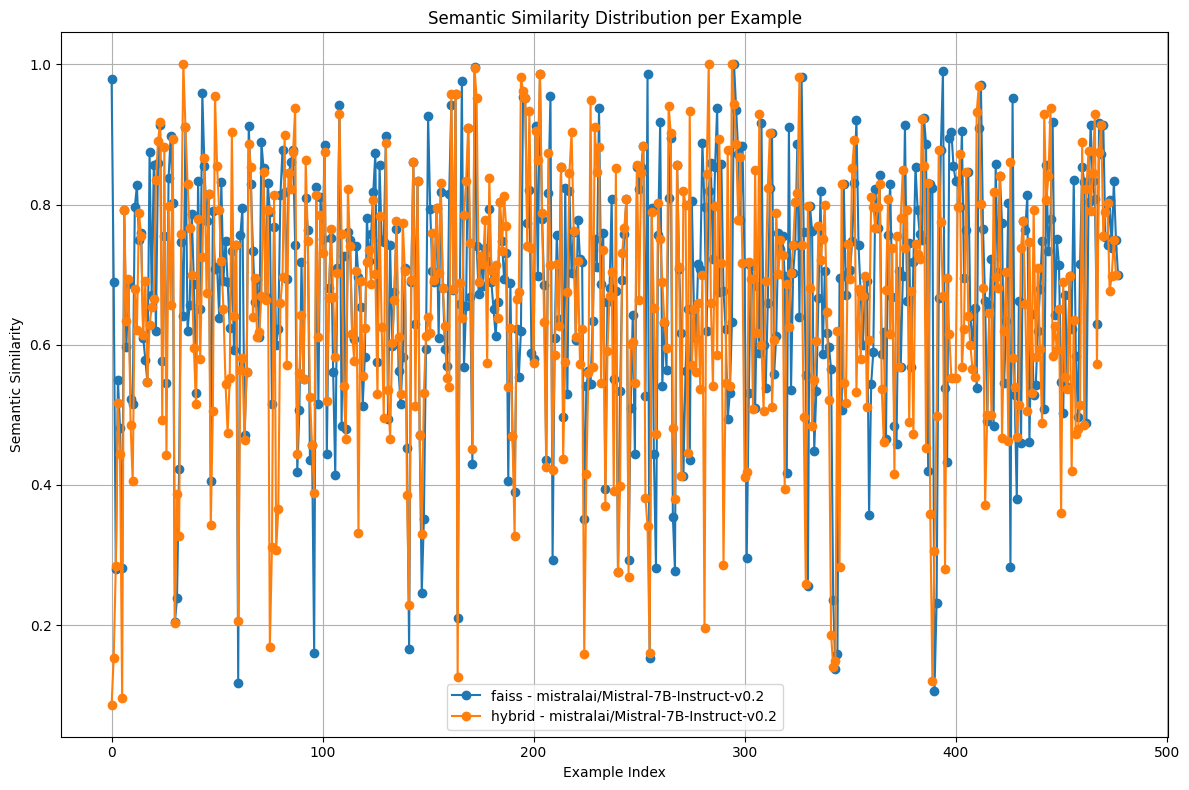

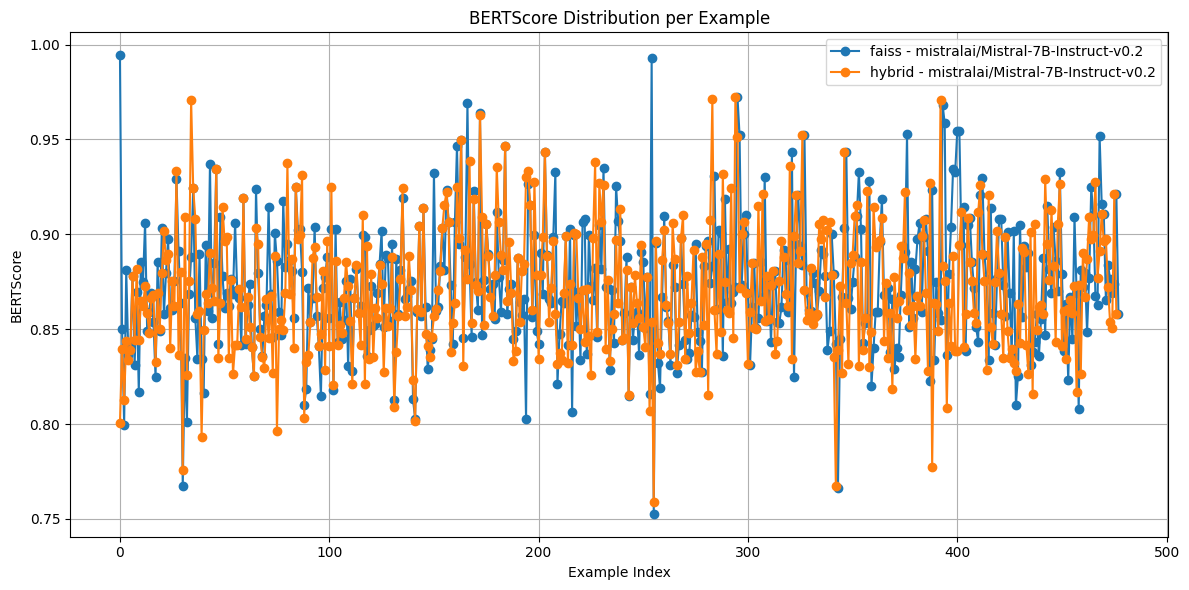

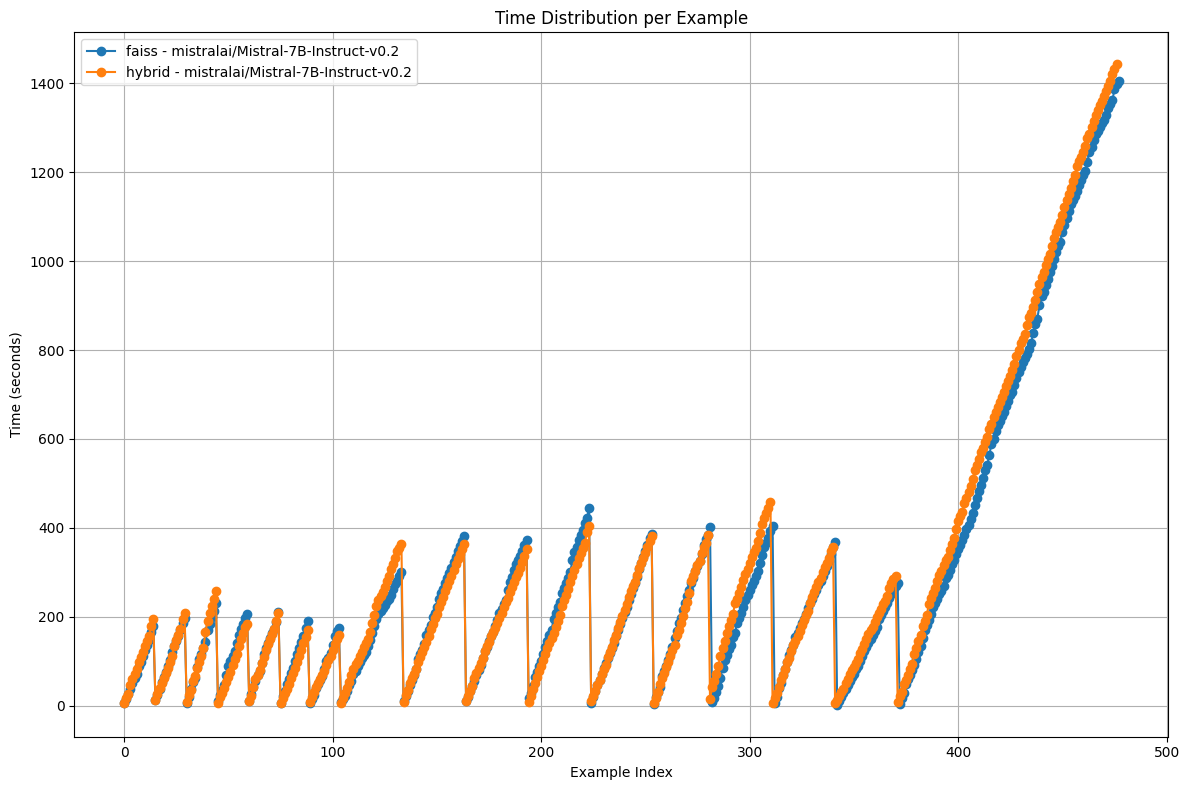

{('faiss', 'mistralai/Mistral-7B-Instruct-v0.2'): {'Semantic Similarity': np.float64(0.678717575827029), 'BERTScore': np.float64(0.8739537261270579), 'ROUGE-L': np.float64(0.3176384357503114), 'Avg Time': np.float64(284.58660206734885)}, ('hybrid', 'mistralai/Mistral-7B-Instruct-v0.2'): {'Semantic Similarity': np.float64(0.6575023675458487), 'BERTScore': np.float64(0.8706583651856556), 'ROUGE-L': np.float64(0.29961661561259584), 'Avg Time': np.float64(292.4349388716356)}}


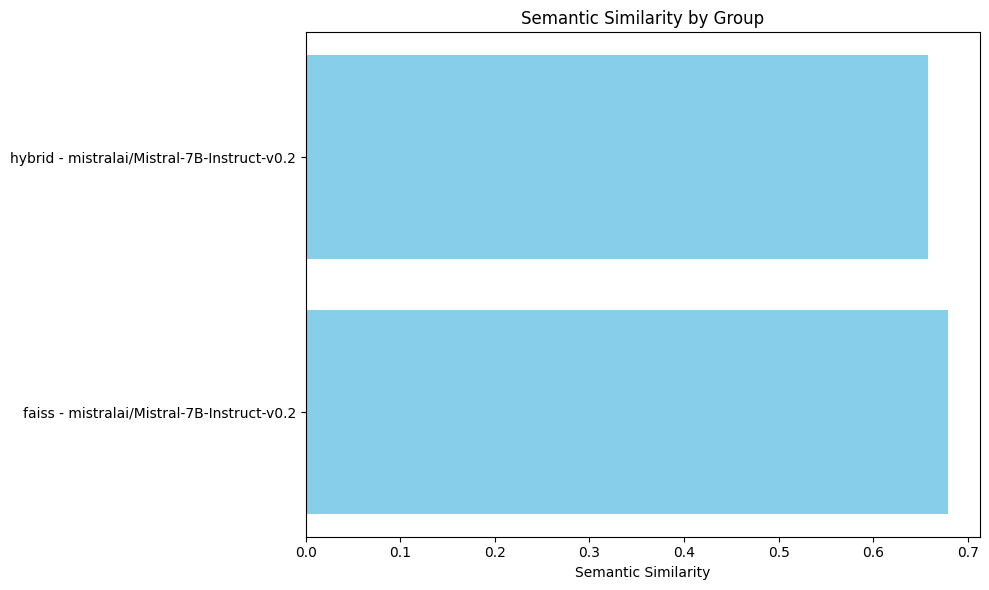

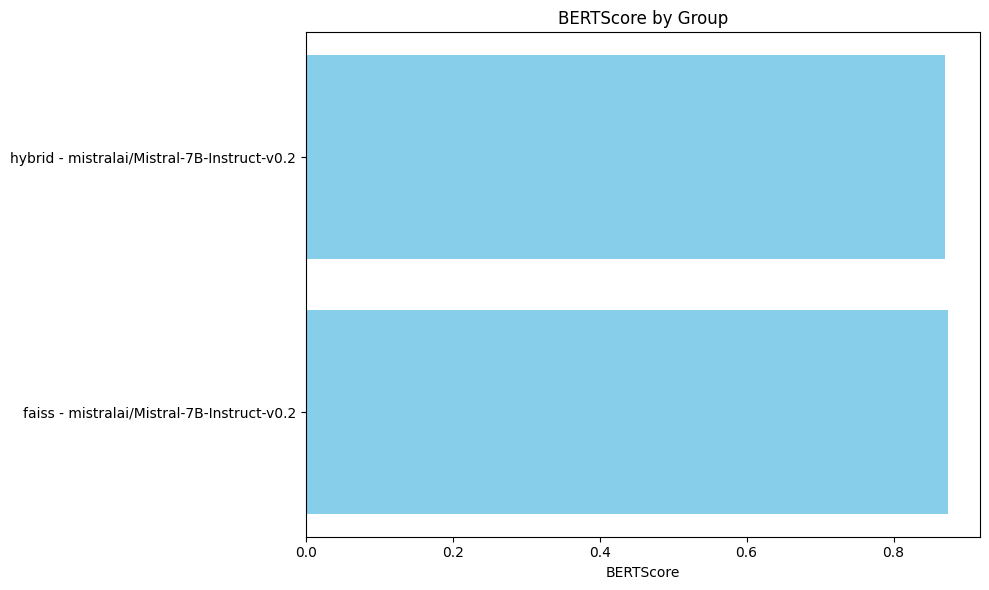

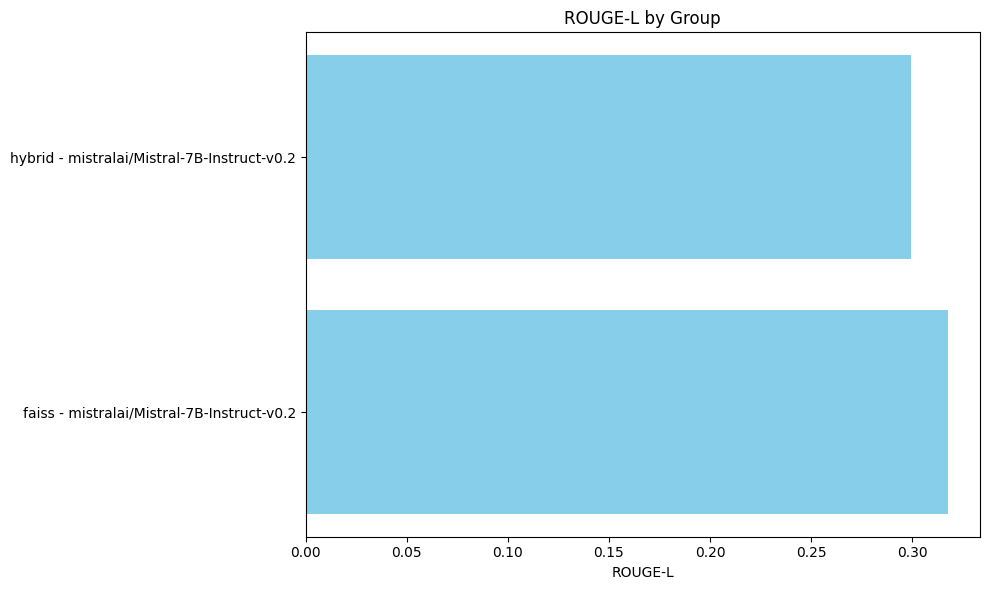

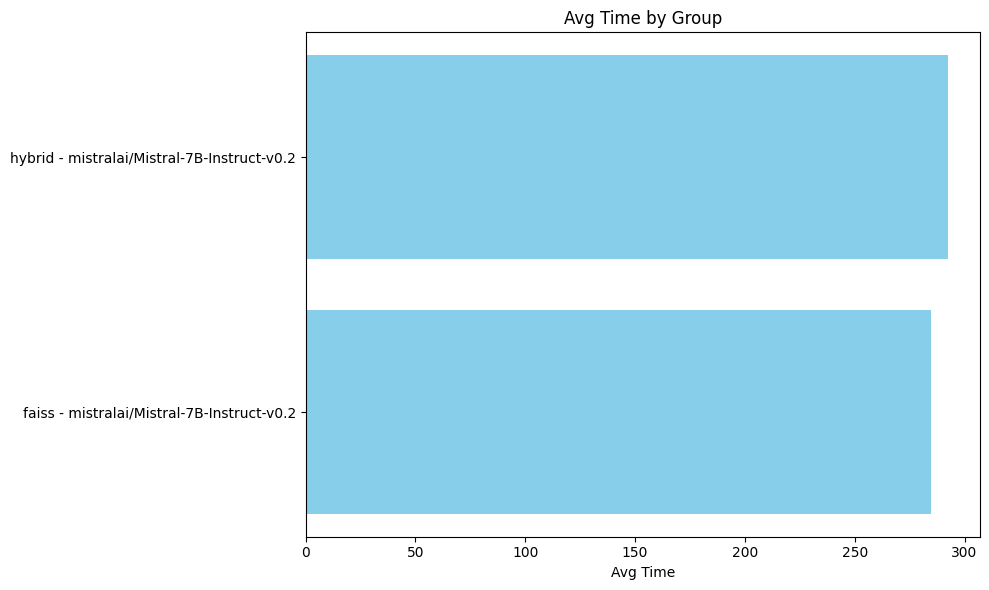

In [14]:
if __name__ == "__main__":
    main()